# PISA 2012 Data Exploration
## by Joe Lalgee

> [PISA](https://www.oecd.org/pisa/) is the OECD's Programme for International Student Assessment. PISA measures 15-year-olds’ ability to use their reading, mathematics and science knowledge and skills to meet real-life challenges. The [PISA 2012 database](https://www.google.com/url?q=https://s3.amazonaws.com/udacity-hosted-downloads/ud507/pisa2012.csv.zip&sa=D&ust=1554482573645000) contains the full set of responses from individual students, school principals and parents for 2012. An [accompanying dictionary](https://www.google.com/url?q=https://s3.amazonaws.com/udacity-hosted-downloads/ud507/pisadict2012.csv&sa=D&ust=1554482573645000) explains the dataset's variables.
> 
> In this exploration of the UK data we will be interested in the effect of explanatory features - gender, month of birth, and family situation (father and mother at home or not, siblings at home or not) - on student mindset (sense of belonging, attitude towards school, perceived control, perseverance and openness for problem solving) and proficiency in mathematics, reading and science.
>
> We will be casting a wide net with exploration of a large number of features, in an attempt to discover something with potential for an interesting multivariate analysis.
> 
> It should be noted that there are [specific requirements](https://www.oecd.org/pisa/data/httpoecdorgpisadatabase-instructions.htm) for analysing this dataset to ensure unbiased results. These include the application of weights for obtaining unbiased population parameter estimates, replicate weights for obtaining unbiased standard errors, and the use of a set of plausible values for the calculation of student proficiency estimates.
>
> It should also be noted that the student mindset responses in particular cannot be regarded as independent of one another.
>
> Therefore, while a thorough exploration would need to include tests for statistical significance, these will be omitted here as the calculations are rather complex, and outside the scope of this project.

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from math import sqrt
from re import finditer
from sqlalchemy import create_engine

%matplotlib inline
base_color = sb.color_palette()[0]

### Gather data

> As the full dataset is over 2Gb, we will first store it in a database, and then extract relevant data for our exploration, using the method outlined by Eric D. Brown, D.Sc. at https://pythondata.com/working-large-csv-files-python/. The students' repsonse data, the calculated plausible values, and the weights data will be housed in separate dataframes as per the "one table per observational unit" principle.
>
> We will also store the dictionary in a dataframe to help generate useful labels on visualisations.

#### Store data in database

In [2]:
# Create a sqllite database to hold the full dataset
csv_db = create_engine('sqlite:///pisa2012.db')

In [ ]:
# Iterate through CSV file in chunks and store the data into sqllite
i = 0
j = 1
for df in pd.read_csv('pisa2012.csv', chunksize=100000, iterator=True,  encoding = 'ISO-8859-1', dtype=str):
    df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
    df.index += j
    i+=1
    df.to_sql('pisa', csv_db, if_exists='append')
    j = df.index[-1] + 1

#### Student repsonses dataframe

In [3]:
# Find out how countries are represented in the CNT column
select = 'SELECT DISTINCT CNT FROM pisa'
df_cnt = pd.read_sql_query(select, csv_db)
df_cnt.head()

,CNT
0,Albania
1,United Arab Emirates
2,Argentina
3,Australia
4,Austria


In [4]:
# Check UK is represented in the same way
df_cnt[df_cnt['CNT']=='United Kingdom']

,CNT
20,United Kingdom


In [5]:
# Create list of columns needed for student repsonse data
cols = ['STIDSTD', 'ST03Q01', 'ST04Q01'] # student ID, month of birth, gender
cols += ['ST11Q0{}'.format(str(i)) for i in range(1, 5)] # family situation

# (put list of mindset question columns in a separate variable for later use)
mindset_cols = ['ST87Q0{}'.format(str(i)) for i in range(1, 10)] # sense of belonging
mindset_cols += ['ST88Q0{}'.format(str(i)) for i in range(1, 5)] # attitude towards school
mindset_cols += ['ST89Q0{}'.format(str(i)) for i in range(2, 6)] # attitude towards school
mindset_cols += ['ST91Q0{}'.format(str(i)) for i in range(1, 7)] # perceived control
mindset_cols += ['ST93Q01', 'ST93Q03', 'ST93Q04', 'ST93Q06', 'ST93Q07'] # perseverence
mindset_cols += ['ST94Q05', 'ST94Q06', 'ST94Q09', 'ST94Q10', 'ST94Q14'] # openness for problem solving

cols += mindset_cols

# Prepare select statement for student repsonse data (UK only)
select = 'SELECT {} FROM pisa WHERE CNT = "United Kingdom"'.format(','.join(cols))

# Read in the student repsonse data
df_resp = pd.read_sql_query(select, csv_db)

# Set index and verify it looks as expected
df_resp.set_index('STIDSTD', inplace=True)
df_resp.head()

,ST03Q01,ST04Q01,ST11Q01,ST11Q02,ST11Q03,ST11Q04,ST87Q01,ST87Q02,ST87Q03,ST87Q04,...,ST93Q01,ST93Q03,ST93Q04,ST93Q06,ST93Q07,ST94Q05,ST94Q06,ST94Q09,ST94Q10,ST94Q14
STIDSTD,,,,,,,,,,,,,,,,,,,,,
00001,11,Female,Yes,Yes,Yes,Yes,Strongly disagree,Strongly agree,Strongly agree,Strongly disagree,...,Very much like me,Very much like me,Somewhat like me,Mostly like me,Somewhat like me,Somewhat like me,Not much like me,Very much like me,Very much like me,Mostly like me
00002,11,Male,Yes,Yes,No,No,None,None,None,None,...,Mostly like me,Mostly like me,Somewhat like me,Not much like me,Somewhat like me,Not much like me,Somewhat like me,Somewhat like me,Not much like me,Not much like me
00003,02,Female,Yes,Yes,Yes,No,Strongly disagree,Disagree,Agree,Strongly disagree,...,None,None,None,None,None,None,None,None,None,None
00004,10,Male,Yes,No,Yes,No,Strongly disagree,Agree,Agree,Strongly disagree,...,Not much like me,Not much like me,Mostly like me,Very much like me,Mostly like me,Mostly like me,Mostly like me,Very much like me,Somewhat like me,Mostly like me
00005,08,Female,Yes,Yes,Yes,Yes,Agree,Agree,Disagree,Disagree,...,None,None,None,None,None,None,None,None,None,None


#### Plausible values dataframe

In [6]:
# Create list of columns needed for plausible values data
cols = ['STIDSTD'] # student ID
cols += ['PV{}MATH'.format(str(i)) for i in range(1, 6)] # plausible values for mathematics
cols += ['PV{}READ'.format(str(i)) for i in range(1, 6)] # plausible values for reading
cols += ['PV{}SCIE'.format(str(i)) for i in range(1, 6)] # plausible values for science

# Prepare select statement for plausible values data (UK only)
select = 'SELECT {} FROM pisa WHERE CNT = "United Kingdom"'.format(','.join(cols))

# Read in the plausible values data
df_plaus = pd.read_sql_query(select, csv_db)

# Set index and verify it looks as expected
df_plaus.set_index('STIDSTD', inplace=True)
df_plaus.head()

,PV1MATH,PV2MATH,PV3MATH,PV4MATH,PV5MATH,PV1READ,PV2READ,PV3READ,PV4READ,PV5READ,PV1SCIE,PV2SCIE,PV3SCIE,PV4SCIE,PV5SCIE
STIDSTD,,,,,,,,,,,,,,,
00001,422.6593,461.6062,476.406,416.4278,409.4174,440.9255,464.7548,478.2581,409.1531,439.3369,447.445,516.4491,556.5461,457.7023,476.3521
00002,401.3164,386.5166,359.2538,416.8952,398.9796,408.0916,367.1924,379.2216,383.2313,411.2994,430.2872,370.608,379.9329,431.2197,391.1227
00003,664.5973,653.6922,626.4294,646.6817,638.1134,597.484,657.0573,641.9654,638.7881,616.5475,701.7344,671.8948,632.7303,632.7303,642.9877
00004,623.4694,614.1221,660.8584,601.6591,599.3223,602.0821,636.5657,661.426,589.251,589.251,667.3256,639.351,697.1652,630.9586,637.486
00005,391.4239,414.0131,361.0453,345.4666,397.6554,425.357,406.2936,407.8822,380.8756,399.1448,424.972,436.1619,396.9974,415.6471,451.0817


#### Weights dataframe

In [7]:
# Create list of columns needed for weights data
cols = ['STIDSTD', 'W_FSTUWT', 'WVARSTRR', 'VAR_UNIT'] # student ID, final student weight,
                                                       # rnd final var stratum, rnd var unit
cols += ['W_FSTR{}'.format(str(i)) for i in range(1, 81)] # student replicant weights

# Prepare select statement for weights data (UK only)
select = 'SELECT {} FROM pisa WHERE CNT = "United Kingdom"'.format(','.join(cols))

# Read in the weights data
df_weights = pd.read_sql_query(select, csv_db)

# Set index and verify it looks as expected
df_weights.set_index('STIDSTD', inplace=True)
df_weights.head()

,W_FSTUWT,WVARSTRR,VAR_UNIT,W_FSTR1,W_FSTR2,W_FSTR3,W_FSTR4,W_FSTR5,W_FSTR6,W_FSTR7,...,W_FSTR71,W_FSTR72,W_FSTR73,W_FSTR74,W_FSTR75,W_FSTR76,W_FSTR77,W_FSTR78,W_FSTR79,W_FSTR80
STIDSTD,,,,,,,,,,,,,,,,,,,,,
00001,8.7358,29,1,13.5879,4.2169,4.2169,4.2169,4.2169,13.5879,4.2169,...,13.5879,13.5879,13.5879,4.2169,4.2169,13.5879,4.2169,4.2169,13.5879,13.5879
00002,11.2771,29,1,21.1565,4.72,4.72,4.72,4.72,21.1565,4.72,...,21.1565,21.1565,21.1565,4.72,4.72,21.1565,4.72,4.72,21.1565,21.1565
00003,8.7358,29,1,13.5879,4.2169,4.2169,4.2169,4.2169,13.5879,4.2169,...,13.5879,13.5879,13.5879,4.2169,4.2169,13.5879,4.2169,4.2169,13.5879,13.5879
00004,11.2771,29,1,21.1565,4.72,4.72,4.72,4.72,21.1565,4.72,...,21.1565,21.1565,21.1565,4.72,4.72,21.1565,4.72,4.72,21.1565,21.1565
00005,8.7358,29,1,13.5879,4.2169,4.2169,4.2169,4.2169,13.5879,4.2169,...,13.5879,13.5879,13.5879,4.2169,4.2169,13.5879,4.2169,4.2169,13.5879,13.5879


#### Question text dataframe

In [8]:
# Read in the question texts data from the accompanying dictionary
df_texts = pd.read_csv('pisadict2012.csv', encoding = 'ISO-8859-1')

# Strip out all but the questions of interest
df_texts.rename(columns={'Unnamed: 0':'shortcode', 'x':'text'}, inplace=True)
df_texts = df_texts[df_texts['shortcode'].isin(mindset_cols)]

# Split question text into question_set and question for later use
df_texts[['question_set', 'question']] = df_texts['text'].str.split(r'\s?-\s?', expand=True)

### Clean data

#### Missing data: Assess

> We will check each dataframe for missing values. There shouldn't be any missing values in the plausible values or weight dataframes, but we need to verify whether all students responded in full to the same set of questions.

In [9]:
df_resp.isna().sum().sum()

152199

In [10]:
df_plaus.isna().sum().sum()

0

In [11]:
df_weights.isna().sum().sum()

0

> We will further investigate the pattern of missing data in the student repsonse data to discover the best way forward.

In [12]:
# Check which columns are missing data
df_resp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12659 entries, 00001 to 12659
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ST03Q01  12659 non-null  object
 1   ST04Q01  12659 non-null  object
 2   ST11Q01  12287 non-null  object
 3   ST11Q02  11496 non-null  object
 4   ST11Q03  10273 non-null  object
 5   ST11Q04  10015 non-null  object
 6   ST87Q01  8248 non-null   object
 7   ST87Q02  8256 non-null   object
 8   ST87Q03  8218 non-null   object
 9   ST87Q04  8225 non-null   object
 10  ST87Q05  8213 non-null   object
 11  ST87Q06  8239 non-null   object
 12  ST87Q07  8217 non-null   object
 13  ST87Q08  8204 non-null   object
 14  ST87Q09  8226 non-null   object
 15  ST88Q01  8254 non-null   object
 16  ST88Q02  8236 non-null   object
 17  ST88Q03  8260 non-null   object
 18  ST88Q04  8244 non-null   object
 19  ST89Q02  8244 non-null   object
 20  ST89Q03  8239 non-null   object
 21  ST89Q04  8237 non-null   object
 22 

In [13]:
# Check how many rows are complete
(df_resp.isna().sum(axis=1) == 0).sum()

2605

In [14]:
# Check what values are present for ST11Q01-04 (family situation)
print(df_resp['ST11Q01'].value_counts())
print(df_resp['ST11Q02'].value_counts())
print(df_resp['ST11Q03'].value_counts())
print(df_resp['ST11Q04'].value_counts())

Yes    11991
No       296
Name: ST11Q01, dtype: int64
Yes    9768
No     1728
Name: ST11Q02, dtype: int64
Yes    6752
No     3521
Name: ST11Q03, dtype: int64
Yes    6283
No     3732
Name: ST11Q04, dtype: int64


> There is missing data in the student responses dataframe, including `ST11Q01-04` (family situation).

#### Missing data: Define

> For the analysis planned, it will be essential to have values for `ST11Q01-04` (family situation), but the other repsonses are not so critical at an individual student level. Therefore we will remove rows for which data is missing for any of `ST11Q01-04` (family situation).

#### Missing data: Code

In [15]:
# Create list of index values to drop
to_drop = df_resp[df_resp['ST11Q01'].isna() |
                  df_resp['ST11Q02'].isna() |
                  df_resp['ST11Q03'].isna() |
                  df_resp['ST11Q04'].isna()].index.values
len(to_drop)

4108

In [16]:
# Create copy of student response dataframe for cleaned data, and drop rows
df_resp_clean = df_resp.copy()
df_resp_clean.drop(to_drop, inplace=True)

#### Missing data: Test

In [17]:
# Check for missing data in ST11Q01-04 (family situation)
len(df_resp_clean[df_resp_clean['ST11Q01'].isna() |
                  df_resp_clean['ST11Q02'].isna() |
                  df_resp_clean['ST11Q03'].isna() |
                  df_resp_clean['ST11Q04'].isna()])

0

In [18]:
# Check how much data is left in each column
df_resp_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8551 entries, 00001 to 12659
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ST03Q01  8551 non-null   object
 1   ST04Q01  8551 non-null   object
 2   ST11Q01  8551 non-null   object
 3   ST11Q02  8551 non-null   object
 4   ST11Q03  8551 non-null   object
 5   ST11Q04  8551 non-null   object
 6   ST87Q01  5600 non-null   object
 7   ST87Q02  5607 non-null   object
 8   ST87Q03  5583 non-null   object
 9   ST87Q04  5592 non-null   object
 10  ST87Q05  5578 non-null   object
 11  ST87Q06  5600 non-null   object
 12  ST87Q07  5589 non-null   object
 13  ST87Q08  5577 non-null   object
 14  ST87Q09  5595 non-null   object
 15  ST88Q01  5611 non-null   object
 16  ST88Q02  5598 non-null   object
 17  ST88Q03  5612 non-null   object
 18  ST88Q04  5600 non-null   object
 19  ST89Q02  5599 non-null   object
 20  ST89Q03  5601 non-null   object
 21  ST89Q04  5596 non-null   object
 22  

#### Datatypes: Assess

In [19]:
# Check what values are present in each column
for col, vals in df_resp_clean.iteritems():
    print(f'{col}:{vals.unique()}\n')

ST03Q01:['11' '02' '10' '08' '09' '03' '01' '07' '06' '05' '04' '12']

ST04Q01:['Female' 'Male']

ST11Q01:['Yes' 'No']

ST11Q02:['Yes' 'No']

ST11Q03:['Yes' 'No']

ST11Q04:['Yes' 'No']

ST87Q01:['Strongly disagree' None 'Agree' 'Disagree' 'Strongly agree']

ST87Q02:['Strongly agree' None 'Disagree' 'Agree' 'Strongly disagree']

ST87Q03:['Strongly agree' None 'Agree' 'Disagree' 'Strongly disagree']

ST87Q04:['Strongly disagree' None 'Disagree' 'Agree' 'Strongly agree']

ST87Q05:['Agree' None 'Disagree' 'Strongly agree' 'Strongly disagree']

ST87Q06:['Strongly disagree' None 'Disagree' 'Agree' 'Strongly agree']

ST87Q07:['Agree' None 'Strongly agree' 'Disagree' 'Strongly disagree']

ST87Q08:['Agree' None 'Disagree' 'Strongly agree' 'Strongly disagree']

ST87Q09:['Strongly agree' None 'Agree' 'Strongly disagree' 'Disagree']

ST88Q01:['Strongly agree' None 'Disagree' 'Agree' 'Strongly disagree']

ST88Q02:['Disagree' None 'Strongly disagree' 'Agree' 'Strongly agree']

ST88Q03:['Agree' None 

> All data is currently stored as strings.

#### Datatypes: Define

> We will want boolean datatypes for `ST11Q01-04` (family situation).
>
> We will want categorical datatypes for other columns in the student response data, with all ordered bar `ST04Q01` (gender).
>
> For `ST03Q01` (birth month), we will want the order to ascend through the months of the academic year (September to August).
>
> For the mindset responses, we will want the order to ascend from positive mindset to negative mindset, so that on visualisations, the most positive response appears in the top row. This means for example that `ST87Q02` (Sense of Belonging - Make Friends Easily) will be ordered from `Strongly Agree` to `Strongly Disagree`, whereas `ST87Q01` (Sense of Belonging - Feel Like Outsider) will be ordered from `Strongly Disagree` to `Strongly Agree`. This will aid interpretation of grouped visualisations.
>
> We will want the plausible values and weights data as floats, bar `WVARSTRR` (randomised final variance stratum) and `VAR_UNIT` (randomly assigned variance unit) which we will want as integers.

#### Datatypes: Code

In [20]:
# Convert ST04Q01 (gender) to categorical datatype
df_resp_clean['ST04Q01'] = df_resp_clean['ST04Q01'].astype('category')

In [21]:
# Convert ST11Q01-04 (family situation) to boolean datatypes
cols = ['ST11Q0{}'.format(str(i)) for i in range(1,5)]

for col in cols:
    df_resp_clean[col] = df_resp_clean[col].map({'Yes':True, 'No':False})

In [22]:
# Convert ST03Q01 (month of birth) to an ordered categorical datatype, 
# running from September to August (as UK school year begins in September)
df_resp_clean['ST03Q01'] = pd.Categorical(df_resp_clean['ST03Q01'], ordered=True,
                                          categories=['09', '10', '11', '12', '01', '02', 
                                                      '03', '04', '05', '06', '07', '08'])

In [23]:
# Convert any "Strongly agree"->"Strongly disagree" columns for positive questions
# to an ordered categorical datatype
cols = ['ST87Q02', 'ST87Q03', 'ST87Q05', 'ST87Q07', 'ST87Q08', 'ST87Q09',
        'ST88Q03', 'ST88Q04',
        'ST89Q02', 'ST89Q03', 'ST89Q04', 'ST89Q05',
        'ST91Q01', 'ST91Q02', 'ST91Q05']

for col in cols:
    df_resp_clean[col] = pd.Categorical(df_resp_clean[col], ordered=True,
                                          categories=['Strongly agree', 'Agree', 'Disagree', 'Strongly disagree'])

In [24]:
# Convert any "Strongly disagree"->"Strongly agree" columns for negative questions
# to an ordered categorical datatype
cols = ['ST87Q01', 'ST87Q04', 'ST87Q06', 
        'ST88Q01', 'ST88Q02',
        'ST91Q03', 'ST91Q04', 'ST91Q06']

for col in cols:
    df_resp_clean[col] = pd.Categorical(df_resp_clean[col], ordered=True,
                                          categories=['Strongly disagree', 'Disagree', 'Agree', 'Strongly agree'])

In [25]:
# Convert any "Very much like me"->"Not at all like me" columns for positive questions
# to an ordered categorical datatype
cols = ['ST93Q04', 'ST93Q06', 'ST93Q07', 
        'ST94Q05', 'ST94Q06', 'ST94Q09', 'ST94Q10', 'ST94Q14']

for col in cols:
    df_resp_clean[col] = pd.Categorical(df_resp_clean[col], ordered=True,
                                          categories=['Very much like me', 'Mostly like me', 'Somewhat like me', 
                                                      'Not much like me', 'Not at all like me'])

In [26]:
# Convert any "Not at all like me"->"Very much like me" columns for negative questions
# to an ordered categorical datatype
cols = ['ST93Q01', 'ST93Q03']

for col in cols:
    df_resp_clean[col] = pd.Categorical(df_resp_clean[col], ordered=True,
                                          categories=['Not at all like me', 'Not much like me', 'Somewhat like me', 
                                                      'Mostly like me',  'Very much like me'])

In [27]:
# Create copies of plausible values and weights dataframes for cleaned data as floats
df_plaus_clean = df_plaus.astype('float64')
df_weights_clean = df_weights.astype('float64')

In [28]:
# Convert WVARSTRR (randomised final variance stratum)
# and VAR_UNIT (randomly assigned variance unit) to integers
df_weights_clean['WVARSTRR'] = df_weights_clean['WVARSTRR'].astype('int64')
df_weights_clean['VAR_UNIT'] = df_weights_clean['VAR_UNIT'].astype('int64')

#### Datatypes: Test

In [29]:
# Check datatypes for each dataframe
print(df_resp_clean.info())
print(df_plaus_clean.info())
print(df_weights_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8551 entries, 00001 to 12659
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   ST03Q01  8551 non-null   category
 1   ST04Q01  8551 non-null   category
 2   ST11Q01  8551 non-null   bool    
 3   ST11Q02  8551 non-null   bool    
 4   ST11Q03  8551 non-null   bool    
 5   ST11Q04  8551 non-null   bool    
 6   ST87Q01  5600 non-null   category
 7   ST87Q02  5607 non-null   category
 8   ST87Q03  5583 non-null   category
 9   ST87Q04  5592 non-null   category
 10  ST87Q05  5578 non-null   category
 11  ST87Q06  5600 non-null   category
 12  ST87Q07  5589 non-null   category
 13  ST87Q08  5577 non-null   category
 14  ST87Q09  5595 non-null   category
 15  ST88Q01  5611 non-null   category
 16  ST88Q02  5598 non-null   category
 17  ST88Q03  5612 non-null   category
 18  ST88Q04  5600 non-null   category
 19  ST89Q02  5599 non-null   category
 20  ST89Q03  5601 non-null   categ

#### Column names: Assess

> Column names are all in shortcode form.

#### Column names: Define

> Most column names will be left unaltered in shortcode form, rather than being converted to descriptive values such as those in the accompanying dictionary for the following reasons:
> 
> * The short column names are helpful when viewing the data in tabular form on screen.
> * The format of the column names makes it easy to iterate over a group of related columns e.g. questions within a group, replicant weights.
> * We plan to process descriptive text for use in the visualisations anyway, so uninterpretable feature names will not be exposed.
> 
> However it would be useful to have more descriptive column names for the ID, explanatory features, and final student weight as these will be used frequently throughout the code.

#### Column names: Code

In [30]:
# Rename columns for ID, explanatory features and final student weight
df_resp_clean.index.rename('ID', inplace=True)
df_resp_clean.rename(columns={'ST03Q01':'birth_month', 
                              'ST04Q01':'gender',
                              'ST11Q01':'mother_home', 
                              'ST11Q02':'father_home', 
                              'ST11Q03':'brother_home', 
                              'ST11Q04':'sister_home'}, inplace=True)

df_plaus_clean.index.rename('ID', inplace=True)

df_weights_clean.rename(columns={'W_FSTUWT':'weight'}, inplace=True)
df_weights_clean.index.rename('ID', inplace=True)

#### Column names: Test

In [31]:
# Check column and index names
print(df_resp_clean.columns)
print(df_resp_clean.index.name)
print(df_plaus_clean.index.name)
print(df_weights_clean.index.name)

Index(['birth_month', 'gender', 'mother_home', 'father_home', 'brother_home',
       'sister_home', 'ST87Q01', 'ST87Q02', 'ST87Q03', 'ST87Q04', 'ST87Q05',
       'ST87Q06', 'ST87Q07', 'ST87Q08', 'ST87Q09', 'ST88Q01', 'ST88Q02',
       'ST88Q03', 'ST88Q04', 'ST89Q02', 'ST89Q03', 'ST89Q04', 'ST89Q05',
       'ST91Q01', 'ST91Q02', 'ST91Q03', 'ST91Q04', 'ST91Q05', 'ST91Q06',
       'ST93Q01', 'ST93Q03', 'ST93Q04', 'ST93Q06', 'ST93Q07', 'ST94Q05',
       'ST94Q06', 'ST94Q09', 'ST94Q10', 'ST94Q14'],
      dtype='object')
ID
ID
ID


#### Computed variables: Assess

> We have no features to indicate the following:
>
> * both father and mother at home or not
> * siblings at home or not

#### Computed variables: Define

> We will compute and store boolean features as follows:
>
> * both father and mother at home or not: `mother_and_father_home`
> * siblings at home or not: `siblings_home`
>
> Note: some uncommon family situations to be aware of are:
>
> * two fathers or two mothers and home will be classified as father_and_mother_home: no
> * neither father nor mother will be classified as father_and_mother_home: no
> * all siblings left home will be classified as siblings_home: no

#### Computed variables: Code

In [32]:
# Compute and store mother_and_father_home
df_resp_clean['mother_and_father_home'] = df_resp_clean['mother_home'] & df_resp_clean['father_home']

In [33]:
# Compute and store siblings_home
df_resp_clean['siblings_home'] = df_resp_clean['brother_home'] | df_resp_clean['sister_home']

#### Computed variables: Test

In [34]:
# Check the student responses dataframe head
df_resp_clean.head()

,birth_month,gender,mother_home,father_home,brother_home,sister_home,ST87Q01,ST87Q02,ST87Q03,ST87Q04,...,ST93Q04,ST93Q06,ST93Q07,ST94Q05,ST94Q06,ST94Q09,ST94Q10,ST94Q14,mother_and_father_home,siblings_home
ID,,,,,,,,,,,,,,,,,,,,,
00001,11,Female,True,True,True,True,Strongly disagree,Strongly agree,Strongly agree,Strongly disagree,...,Somewhat like me,Mostly like me,Somewhat like me,Somewhat like me,Not much like me,Very much like me,Very much like me,Mostly like me,True,True
00002,11,Male,True,True,False,False,NaN,NaN,NaN,NaN,...,Somewhat like me,Not much like me,Somewhat like me,Not much like me,Somewhat like me,Somewhat like me,Not much like me,Not much like me,True,False
00003,02,Female,True,True,True,False,Strongly disagree,Disagree,Agree,Strongly disagree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
00004,10,Male,True,False,True,False,Strongly disagree,Agree,Agree,Strongly disagree,...,Mostly like me,Very much like me,Mostly like me,Mostly like me,Mostly like me,Very much like me,Somewhat like me,Mostly like me,False,True
00005,08,Female,True,True,True,True,Agree,Agree,Disagree,Disagree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True


### What is the structure of your dataset?

> There are four dataframes:
>
> * One contains the student responses and features calculated from them.
> * One contains the plausible values for proficiency in mathematics, reading and science.
> * One contains the weights to be applied during analysis.
> * One contains question text for the mindset questions.
>
> The student responses are boolean or categorical, and most are ordered. Month of birth is ordered beginning at September and ending at August, therefore corresponding to age within the academic year group. Responses to questions on mindset are on a scale ordered from negative mindset to positive mindset.

### What is/are the main feature(s) of interest in your dataset?

> The features of interest are in two groups - the mindset responses, and the proficiency scores to be generated from the plausible values. We are interested in how these features might be affected by gender, month of birth, and family situation. Depending which features of interest show an interesting relationship with the explanatory features, we will select one for multivariate exploration, so in a sense the main feature of interest is yet to be determined.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> The weights and replicant weights will support our investigation by providing unbiased results.

## Univariate Exploration

> In this section, we will investigate distributions of individual variables. If
we see unusual points or outliers, we will take a deeper look to clean things up
and prepare to look at relationships between variables.
>
> As instructed in the [documentation](https://www.oecd.org/pisa/data/httpoecdorgpisadatabase-instructions.htm), we need to incorporate the weights provided in the analysis.

In [35]:
# Join student responses and final student weights
df_resp_weight = df_resp_clean.join(df_weights_clean['weight'])

### Gender

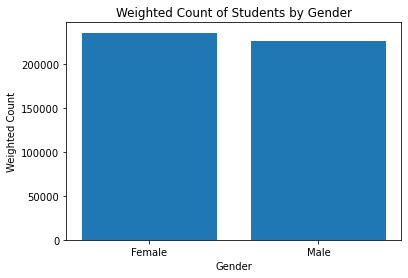

In [36]:
# Calculate the sum of all the student weights grouped by gender
genders = df_resp_weight.groupby('gender')['weight'].sum()

plt.bar(x=genders.index, height=genders)
plt.xlabel('Gender')
plt.ylabel('Weighted Count')
plt.title('Weighted Count of Students by Gender');

> As expected, the split between male and female is roughly even.

### Birth month

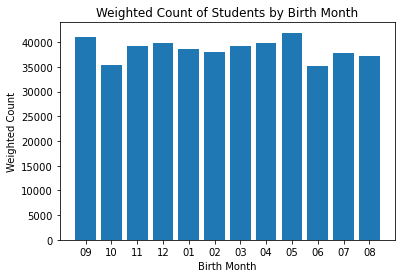

In [37]:
# Calculate the sum of all the student weights grouped by birth_month
birth_months = df_resp_weight.groupby('birth_month')['weight'].sum()

plt.bar(x=birth_months.index, height=birth_months)
plt.xlabel('Birth Month')
plt.ylabel('Weighted Count')
plt.title('Weighted Count of Students by Birth Month');

> As expected, the spread of birth months is roughly even.

### Mother and father home

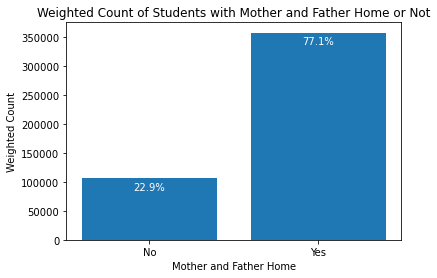

In [38]:
# Calculate the sum of all the student weights grouped by mother_and_father_home
mf_home = df_resp_weight.groupby('mother_and_father_home')['weight'].sum()

plt.bar(x=mf_home.index, height=mf_home)
plt.xlabel('Mother and Father Home')
plt.ylabel('Weighted Count')
plt.title('Weighted Count of Students with Mother and Father Home or Not')
plt.xticks((0, 1), ('No', 'Yes'))
tot = mf_home.sum()

# Add percentages to bars to aid interpretation
for idx, val in mf_home.iteritems():
    pc = 100*val/tot
    plt.text(idx, val-20000, f'{pc:.1f}%', c='w', ha='center');

> 77.1% of students have both father and mother at home. There are enough students in each category for meaningful analysis.

### Siblings home

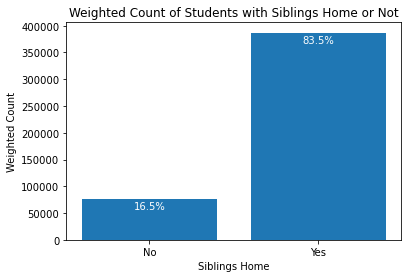

In [39]:
# Calculate the sum of all the student weights grouped by siblings_home
s_home = df_resp_weight.groupby('siblings_home')['weight'].sum()

plt.bar(x=s_home.index, height=s_home)
plt.xlabel('Siblings Home')
plt.ylabel('Weighted Count')
plt.title('Weighted Count of Students with Siblings Home or Not')
plt.xticks((0, 1), ('No', 'Yes'))
tot = s_home.sum()

# Add percentages to bars to aid interpretation
for idx, val in s_home.iteritems():
    pc = 100*val/tot
    plt.text(idx, val-20000, f'{pc:.1f}%', c='w', ha='center');

> 83.5% of students have a sibling at home. There are enough students in each category for meaningful analysis.

### Mindset responses

> Here, for sake of space, we will compress each set of questions into pair of heatmaps - one for positive questions, and one for negative questions. The heatmaps will show the percentage of student weight at each response, for each question. Each column on a heatmap will correspond to a question. The heatmaps will essentially be collections of univariate heatstrips laid side by side.

Define a plotting function for these question sets:

In [40]:
def add_linebreaks(old_labels, line_length):
    ''' This function adds linebreaks to a list of labels to reduce visualisation cluttering '''
    
    new_labels = []
    for label in old_labels:
        
        # Store positions of all spaces, including one after last word
        spaces_pos = [m.start() for m in finditer(' ', label)]
        spaces_pos.append(len(label))
        
        if len(spaces_pos) > 1:
        
            # Determine and store positions of spaces to be replaced with linebreaks, if any
            linebreaks_pos = []
            prev_linebreak = 0
            for i in range(len(spaces_pos) - 1):
                # For each space, check the number of characters between the previous planned linebreak
                # and the space after this one, and plan a linebreak here if needed
                if spaces_pos[i+1] - prev_linebreak > line_length:
                    linebreaks_pos.append(spaces_pos[i])
                    prev_linebreak = linebreaks_pos[-1]

            # Put planned linebreaks in place of spaces
            for linebreak_pos in linebreaks_pos:
                label = label[:linebreak_pos] + '\n' + label[linebreak_pos+1:]   
        
        new_labels.append(label)
    return new_labels

In [41]:
def prep_heatmap_data(data, cols):
    ''' This function prepares raw response data for a seaborn heatmap plot (or pair if needed),
          effectively applying weights, converting counts to percentages, and reshaping.
        data should be a single dataframe.
        cols should be a dictionary {'pos':[], 'neg':[]} or {'pos':[]} or {'neg':[]}
          containing lists of question shortcodes to include.
    '''

    # Prepare a dictionary to hold percentages for each response for each question
    # grouped into positive and negative questions
    percentages = {'pos':{}, 'neg':{}}
    # Prepare a dictionary to hold one dataframe for positive questions and one for negative questions
    df_percentages = {'pos':0, 'neg':0}
    
    # Handle any postive questions, then any negative questions
    for pn in ('pos','neg'):
        if pn in cols:
            # For each question, calculate the percentage of student weight at each response
            # Calculate the total student weight separately for each question to allow for inconsistent missing data
            for col in cols[pn]: 

                weights = data.groupby(col)['weight'].sum()
                total = weights.sum()

                # Store percentage in dictionary using question shortcode as the key
                percentages[pn][col] = 100 * weights / total

            # Convert the dictionary into a dataframe
            df_percentages[pn]=(pd.DataFrame(percentages[pn]))
            
    return df_percentages

In [42]:
def plot_mindset_heatmap(data, cols, facet=''):
    ''' This function plots either a heatmap for one dataframe representing a question set
          or a heatmap showing the difference between two dataframes representing facets of this data
        data should be a single dataframe or a list of two dataframes.
        cols should be a dictionary {'pos':[], 'neg':[]} or {'pos':[]} or {'neg':[]}
          containing lists of question shortcodes to include.
        facet is an optional string to add context to the plot title.
    '''

    # Retrieve and process question texts for x tick labels, based on question shortcode
    labels = {}
    if 'pos' in cols:
        labels['pos'] = [df_texts.loc[df_texts['shortcode']==x]['question'].values[0] for x in cols['pos']]
        labels['pos'] = add_linebreaks(labels['pos'], 12)
    if 'neg' in cols:
        labels['neg'] = [df_texts.loc[df_texts['shortcode']==x]['question'].values[0] for x in cols['neg']]
        labels['neg'] = add_linebreaks(labels['neg'], 12)

    # Retrieve question set text for title
    x = 'pos' if 'pos' in cols else 'neg'
    question_set = df_texts.loc[df_texts['shortcode']==cols[x][0]]['question_set'].values[0]
    
    # Put facet text on new line if present
    facet = facet if facet == '' else ':\n' + facet

    # Either prepare data and formatting for a heatmap of % student weight at each repsonse...
    if isinstance(data, list) == False:
        df_percentages = prep_heatmap_data(data, cols)
        max_percent = 80 # max(max_pos, max_neg)
        min_percent = 0 # max(max_pos, max_neg)
        colormap = 'magma'
        suptitle = f'Percentage of Students Per Response for "{question_set}" questions{facet}'
        ylabel = 'Percentage of students\n(of those who answered the question)'
    
    # ... or prepare data and formatting for a heatmap of the difference in % student weight between two facets
    else:
        df_percentages_1 = prep_heatmap_data(data[0], cols)
        df_percentages_2 = prep_heatmap_data(data[1], cols)
        df_percentages = {'pos':df_percentages_1['pos'] - df_percentages_2['pos'],
                          'neg':df_percentages_1['neg'] - df_percentages_2['neg']}
        colormap = 'BrBG'
        max_percent = 10 # max(max_pos, max_neg)
        min_percent = -10 # max(max_pos, max_neg)
        suptitle = f'Difference in Percentage of Students Per Response for "{question_set}" questions{facet}'
        ylabel = 'Difference in percentage of students\n(of those who answered the question)'

    # Prepare subplots and axes for positive questions, negative questions and colorbar as needed,
    # aiming for roughly consistent cell sizes on heatmaps
    if ('pos' in cols) & ('neg' in cols):
        subplots = 3
        width = 1 * (len(cols['pos']) + len(cols['neg']) + 0.4) + 5
        ratio = [len(cols['pos']) + 0.2,
                 len(cols['neg']) + 0.2,
                 (len(cols['pos']) + len(cols['neg']) + 2) / 30]
    else:
        subplots = 2
        width = len(cols['pos']) + 2.7 if 'pos' in cols else len(cols['neg']) + 2.7
        ratio = [1.5, 0.1]

    fig, ax = plt.subplots(1, subplots, figsize=(width,6), gridspec_kw={'width_ratios': ratio})
    plt.suptitle(suptitle, fontsize=14)

    # Plot heatmap for positive questions
    if 'pos' in cols:
        pos = ax[0]
        plt.sca(pos)
        sb.heatmap(data=df_percentages['pos'], 
                   vmin=min_percent, 
                   vmax=max_percent, 
                   cbar=False, 
                   cmap=colormap, 
                   annot=True)
        plt.title('Positive Questions');
        pos.set_xticklabels(labels['pos'])
        plt.xticks(rotation=90)
        
        # Process repsonse texts for y tick labels
        ylabs = [y.get_text() for y in pos.get_yticklabels()]
        pos.set_yticklabels(add_linebreaks(ylabs, 12))
        plt.yticks(rotation=90, va='center')

    # Plot heatmap for negative questions
    if 'neg' in cols:
        neg = ax[1] if 'pos' in cols else ax[0]
        plt.sca(neg)
        sb.heatmap(data=df_percentages['neg'], 
                   vmin=min_percent, 
                   vmax=max_percent, 
                   cbar=False, 
                   cmap=colormap, 
                   annot=True)
        plt.title('Negative Questions');
        neg.set_xticklabels(labels['neg'])
        plt.xticks(rotation=90)
        
        # Process repsonse texts for y tick labels
        ylabs = [y.get_text() for y in neg.get_yticklabels()]
        neg.set_yticklabels(add_linebreaks(ylabs, 12))
        plt.yticks(rotation=90, va='center')

    # Add colorbar
    cb = ax[-1]
    plt.sca(cb)
    cbar = fig.colorbar(pos.collections[0], cax=cb, ticks=[x for x in range(min_percent, max_percent + 1, 10)])
    cbar.set_ticklabels([str(x)+'%' for x in range(min_percent, max_percent + 1, 10)])
    plt.ylabel(ylabel)

In [43]:
# Prepare lists of the sets of positive and negative questions
qsets = {'belonging':{'pos':['ST87Q02', 'ST87Q03', 'ST87Q05', 'ST87Q07', 'ST87Q08', 'ST87Q09'],
                      'neg':['ST87Q01', 'ST87Q04', 'ST87Q06']},
        'attitude':{'pos':['ST88Q03', 'ST88Q04', 'ST89Q02', 'ST89Q03', 'ST89Q04', 'ST89Q05'],
                    'neg':['ST88Q01', 'ST88Q02']},
        'control':{'pos':['ST91Q01', 'ST91Q02', 'ST91Q05'],
                  'neg':['ST91Q03', 'ST91Q04', 'ST91Q06']},
        'persevere':{'pos':['ST93Q04', 'ST93Q06', 'ST93Q07'],
                    'neg':['ST93Q01', 'ST93Q03']},
        'problems':{'pos':['ST94Q05', 'ST94Q06', 'ST94Q09', 'ST94Q10', 'ST94Q14']}
       }

#### Sense of belonging

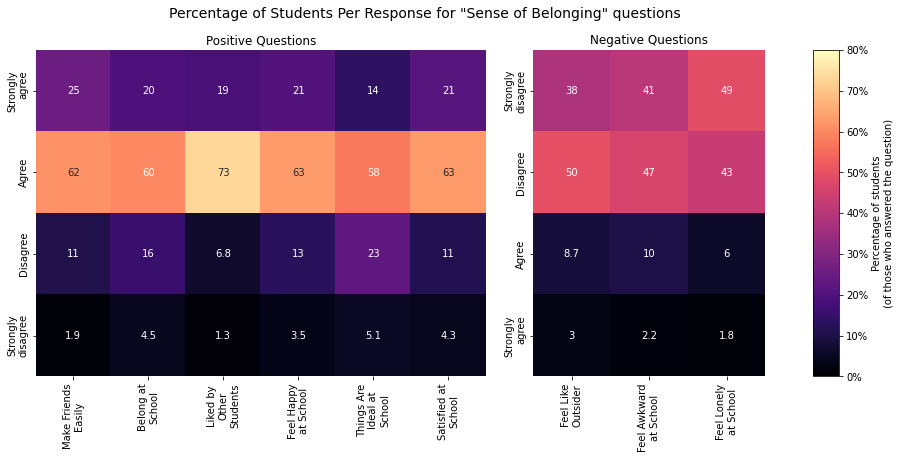

In [44]:
# Plot heatmap
plot_mindset_heatmap(df_resp_weight, qsets['belonging'])

> Here we can see similar repsonses for Sense of Belonging questions, with most students agreeing for positive questions, and disagreeing or strongly disagreeing with negative questions.

#### Attitude towards school

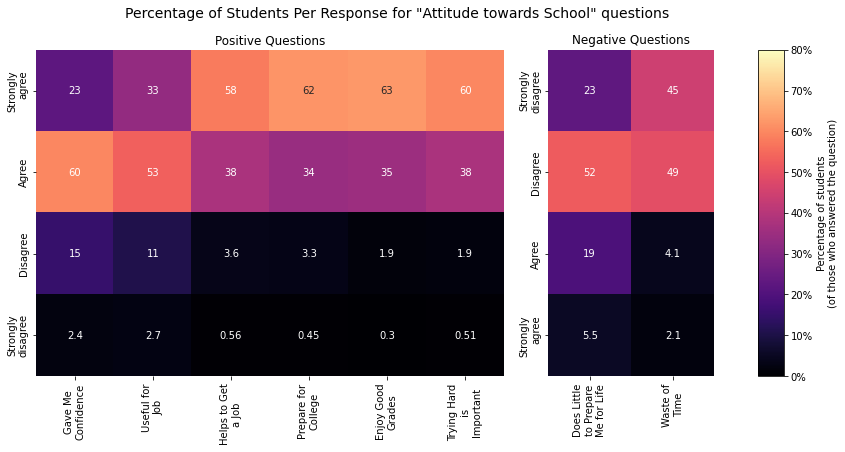

In [45]:
# Plot heatmap
plot_mindset_heatmap(df_resp_weight, qsets['attitude'])

> Here we can see mostly positive repsonses for Attitude towards School questions. Note that the rightmost positive questions have a different ST number in the shortcode e.g. `'ST89Q03'` vs `'ST88Q03'`. The different contexts these questions were asked in may go some way to explain the difference in response patterns. It's interesting to note the difference between `Useful for Job` and `Helps to Get a Job` responses.

#### Perceived control

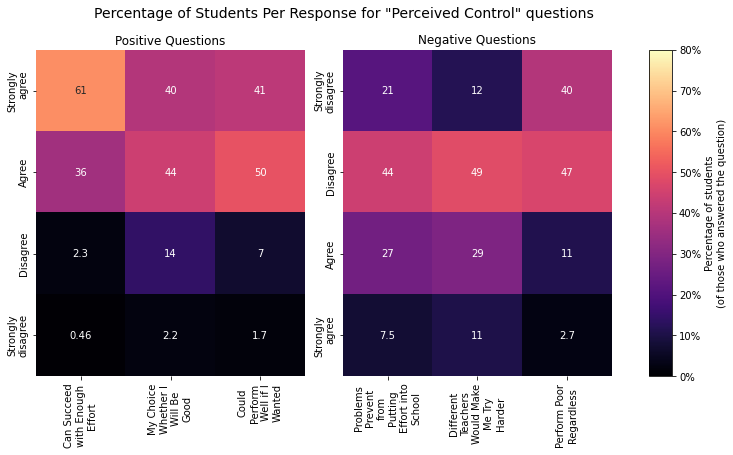

In [46]:
# Plot heatmap
plot_mindset_heatmap(df_resp_weight, qsets['control'])

> There is less consensus on these questions, although the responses are mostly positive.

#### Perseverance

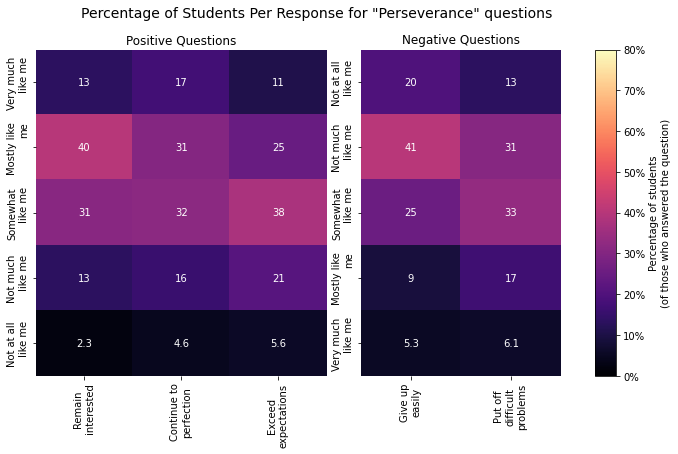

In [47]:
# Plot heatmap
plot_mindset_heatmap(df_resp_weight, qsets['persevere'])

> Here we see low consensus, with most responses being positive or neutral.

#### Openness for Problem Solving

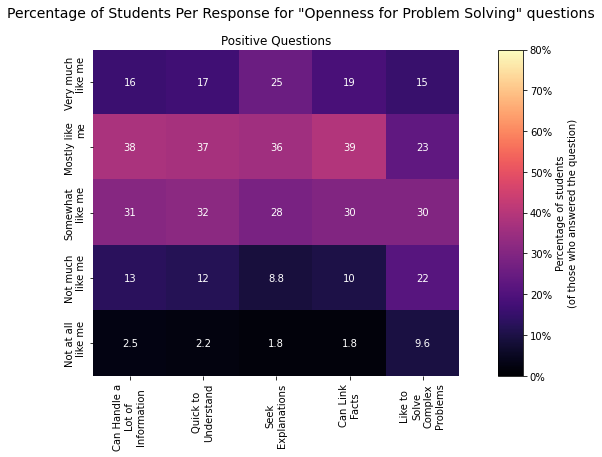

In [48]:
# Plot heatmap
plot_mindset_heatmap(df_resp_weight, qsets['problems'])

> Here we see low consensus again, with most responses being positive or neutral.

### Proficiencies

> The requirements for analysing the proficiencies advise that statistics be calculated for each of the five provided plausible values separately, and then these be averaged. For these histograms, we will therefore simply include all relevant plausible values, and multiply the y-axis scale by 1/5. Note that weights also need to be applied.

In [49]:
# Join plausible values and final student weights
df_plaus_weight = df_plaus_clean.join(df_weights_clean['weight'])
df_plaus_weight.describe()

,PV1MATH,PV2MATH,PV3MATH,PV4MATH,PV5MATH,PV1READ,PV2READ,PV3READ,PV4READ,PV5READ,PV1SCIE,PV2SCIE,PV3SCIE,PV4SCIE,PV5SCIE,weight
count,12659.000000,12659.000000,12659.000000,12659.000000,12659.00000,12659.000000,12659.000000,12659.000000,12659.000000,12659.000000,12659.000000,12659.000000,12659.000000,12659.000000,12659.000000,12659.000000
mean,489.645545,489.517620,489.553247,489.671081,490.23564,498.292310,497.890554,497.822539,498.015016,498.310974,510.043154,509.126798,509.511020,509.382258,509.983267,54.367312
std,91.123682,91.217538,91.106581,91.302125,91.11166,93.002402,93.129530,93.243785,93.336892,92.746463,96.593924,96.693322,96.777692,96.399023,96.889716,64.396607
min,160.001600,145.357500,142.008100,111.863200,159.84580,73.600300,56.117900,119.471500,50.919200,107.442400,139.351000,122.006700,116.971300,110.630400,115.292800,2.770600
25%,427.099200,426.865550,427.255000,426.437150,427.13815,438.075150,438.084300,437.748200,439.207100,438.565500,446.232700,444.927300,444.554300,445.486800,445.486800,9.738700
50%,489.492100,489.102700,488.713200,490.193200,490.27110,500.956800,501.758800,501.372500,501.758800,501.919200,511.413700,511.600100,512.066400,511.693400,512.905600,16.770700
75%,551.651300,551.690250,552.274500,552.586100,552.58610,562.454900,561.463600,562.454900,562.335800,562.105100,576.967500,576.687800,576.967500,576.314800,577.154000,118.380650
max,817.502700,807.610200,807.220800,793.978800,818.12590,812.186000,801.542300,786.529800,825.451000,847.135700,845.897100,844.032100,866.411800,830.790700,866.038800,457.928300


Define a plotting function for the proficiences:

In [50]:
def plot_proficiency_hist(data, cols, bin_width, title):
    ''' This function plots a histogram showing the distribution of a proficency.
        It returns the patches so that legend can be generated outside of the function if needed.
        data should be a single dataframe.
        cols should be a list of the plausible values columns for the proficiency.
        bin_width can be experimented with (int).
        title should be a string containing the proficiency.
    '''
    
    # Put all plausible values in one column, with corresponding weights in second column
    df_all_plaus = pd.DataFrame(columns=['prof', 'weight'])
    for col in cols:
        df_all_plaus = df_all_plaus.append(data[[col, 'weight']].rename(columns={col:'prof'}))
    
    # Define bins
    bins = np.arange(0, df_all_plaus['prof'].max() + bin_width, bin_width)
    
    # Plot histogram, using transparency in case multiple distributions will be 
    # superimposed via multiple function calls
    a,b,hist = plt.hist(data=df_all_plaus, x='prof', weights='weight', bins=bins, alpha=0.5)
    plt.title(f'Distribution of {title} Proficiencies')
    plt.xlabel('Proficiency Score')
    plt.ylabel('Number of Students')
    
    # Rescale y-axis to effectively average the multiple plausible values
    locs, labs = plt.yticks()
    plt.yticks(locs, [int(l/5) for l in locs]);
    
    return hist

Define a function for estimating the mean and its standard error, following [advised procedure](https://www.oecd.org/pisa/data/httpoecdorgpisadatabase-instructions.htm):

In [51]:
def estimate_mean_std_dev(data, cols):
    ''' This function estimates the population mean, its standard error, and the population standard deviation
          for a proficiency
    '''

    # Join replicant weights onto data
    reps = [f'W_FSTR{i}' for i in range(1, 81)]
    data_reps = data.join(df_weights_clean[reps])
    
    # Estimate the population mean
    mean = 0
    for col in cols: # for each pv
        # sum(pv value * weight) / total weight
        mean += (data_reps[col] * data_reps['weight']).sum() / data_reps['weight'].sum()
    # average
    mean = mean / len(cols)
    
    # Compute sampling variance based on one plausible value
    # sum(pv1 value * weight) / total weight
    pv1_mean = (data_reps[cols[0]] * data_reps['weight']).sum() / data_reps['weight'].sum()
    samp_var = 0
    for i in range(1,81): # for each replicant
        # square(replicant pv1 mean - pv1 mean)
        samp_var += ((data_reps[cols[0]] * data_reps[f'W_FSTR{i}']).sum() / data_reps[f'W_FSTR{i}'].sum() - pv1_mean)**2
    samp_var = samp_var / 20
    
    # Compute imputation variance
    impu_var = 0
    for col in cols:
        # square(pv mean - mean)
        impu_var += ((data_reps[col] * data_reps['weight']).sum() / data_reps['weight'].sum() - mean)**2
    impu_var = impu_var / (len(cols) - 1)
    
    # Compute standard error
    std_err = sqrt(samp_var + (1 + (1 / len(cols))) * impu_var)
    
    # Estimate population standard deviation
    std_dev = 0
    for col in cols:
        # sum(square(value - mean) * weight)
        pv_std_dev = (((data_reps[col] - mean)**2) * data_reps['weight']).sum()
        # divide by total weight, and sqrt
        pv_std_dev = sqrt(pv_std_dev / data_reps['weight'].sum())
        std_dev += pv_std_dev
    # average
    std_dev = std_dev / len(cols)
    
    return {'est pop mean':mean, 'std err':std_err, 'est pop std dev':std_dev}

#### Mathematics Proficiency

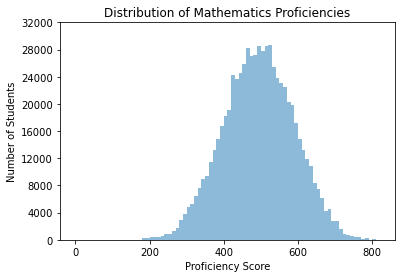

In [52]:
cols = [f'PV{x}MATH' for x in range(1,6)]
hist = plot_proficiency_hist(df_plaus_weight, cols, 10, 'Mathematics');

> The distribution is approximately normal.

In [53]:
# Estimate mean and compute its standard error, estimate standard deviation
cols = [f'PV{x}MATH' for x in range(1,6)]
estimate_mean_std_dev(df_plaus_weight, cols)

{'est pop mean': 493.93423089630403,
 'std err': 3.2892164690208947,
 'est pop std dev': 94.51981443771626}

#### Reading Proficiency

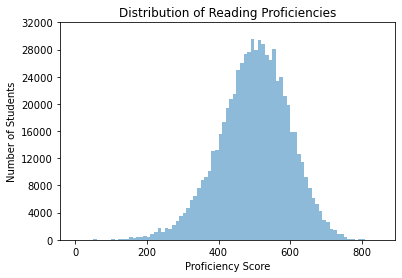

In [54]:
cols = [f'PV{x}READ' for x in range(1,6)]
hist = plot_proficiency_hist(df_plaus_weight, cols, 10, 'Reading');

> The distribution is approximately normal.

In [55]:
# Estimate mean and compute its standard error, estimate standard deviation
cols = [f'PV{x}READ' for x in range(1,6)]
estimate_mean_std_dev(df_plaus_weight, cols)

{'est pop mean': 499.3231151303454,
 'std err': 3.3707570663982365,
 'est pop std dev': 97.20370378170996}

#### Science Proficiency

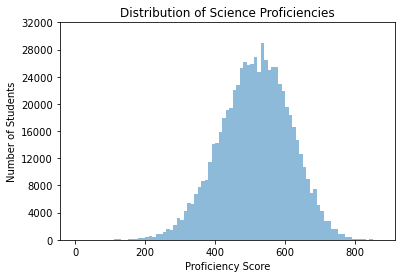

In [56]:
cols = [f'PV{x}SCIE' for x in range(1,6)]
hist = plot_proficiency_hist(df_plaus_weight, cols, 10, 'Science');

> The distribution is approximately normal.

In [57]:
# Estimate mean and compute its standard error, estimate standard deviation
cols = [f'PV{x}SCIE' for x in range(1,6)]
estimate_mean_std_dev(df_plaus_weight, cols)

{'est pop mean': 514.1293210548793,
 'std err': 3.4114960112235395,
 'est pop std dev': 99.76671185399225}

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The explanatory variables (gender, birth month and family situation) were distributed as expected.
>
> The mindset responses for different sets of questions varied in their distribution. Some showed high consensus among students and others showed much lower consensus. All were positive on the whole.
>
> The proficiency scores were distributed roughly according to a normal distribution. The standard errors for the means were nice and small, which should help us to detect any differences in subsets of the sample.


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> The data needed a little cleaning and tidying to put it in a useful form for analysis.
>
> Much work was needed to create functions for analysing and visualising the data. This was partly due to the nature of the data and the complicated sampling methodology employed in gathering it, necessitating use of weights and replicants.
>
> In particular, a lot of work was needed to create the helper functions for displaying the mindset responses in a useful and intuitive format. It was worth going to the effort because later in the analysis we will be able to easily explore facets of the data using the functions that are now available.

## Bivariate Exploration

> In this section, we will explore relationships between pairs of features in our
data.
>
> We will begin by exploring potential interactions between explanatory features.

In [58]:
def plot_biv_hist(data, v1, v2, subtitles, xlabel):
    ''' This function plots a bivariate set of barcharts.
        data should be a single dataframe.
        v1 should be the feature name to vary across subplots (string)
        v2 should be the feature name to vary within subplots (string)
        subtitles should be a list of the titles for each subplot (strings)
        xlabel should be a string
    '''

    # Get lists of the possible values of the categorical/boolean features
    v1_vals = data[v1].cat.categories.tolist() if data[v1].dtype.name == 'category' else data[v1].unique().tolist()
    v2_vals = data[v2].cat.categories.tolist() if data[v2].dtype.name == 'category' else data[v2].unique().tolist()
    
    # Calculate layout attributes for maximum readability
    subs = len(v1_vals)
    bars = len(v2_vals)
    fig_rows = (subs + 2) // 3
    fig_cols = min(subs, 3)

    if bars > 4:
        rot = 90
        ha = 'right'
    else:
        rot = 0
        ha = 'center'
    
    # Prepare subplots and axes
    fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(16,6*fig_rows))
    plt.suptitle(f'Weighted Count of {xlabel}', fontsize=14)
    
    # Plot barcharts
    for i in range(subs):
        plt.sca(ax.flat[i])

        # Calculate the sum of all the student weights grouped by v2
        v1_weights = data[data[v1]==v1_vals[i]].groupby(v2)['weight'].sum()

        plt.bar(x=v1_weights.index, height=v1_weights)
        plt.xlabel(xlabel)
        plt.ylabel('Weighted Count')
        plt.title(subtitles[i])
        plt.xticks(range(bars), [i for i in v1_weights.index])
        tot = v1_weights.sum()
        for idx, val in v1_weights.iteritems():
            pc = 100*val/tot
            plt.text(idx, val*0.9, f'{pc:.1f}%', c='w', ha=ha, va='center',
                     rotation=rot, rotation_mode='anchor');

### Gender and birth month

> We will assume no interaction between these two variables as they are independent.

### Gender and family situation

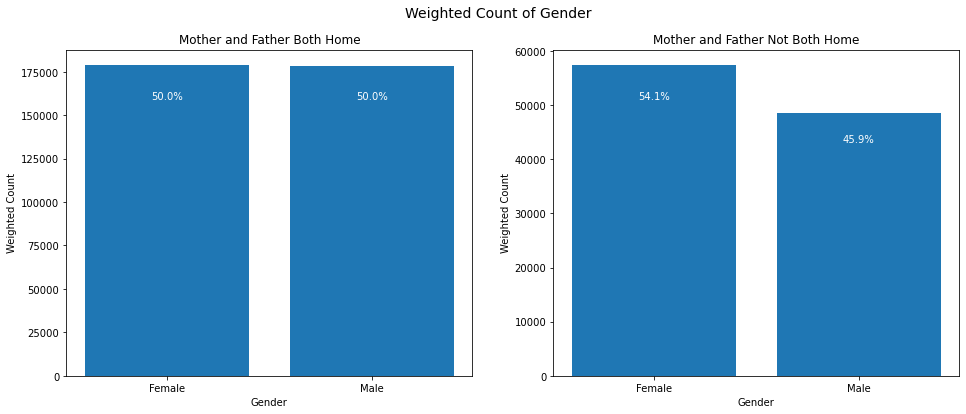

In [59]:
plot_biv_hist(df_resp_weight,
              'mother_and_father_home',
              'gender',
              ['Mother and Father Both Home', 'Mother and Father Not Both Home'],
              'Gender')

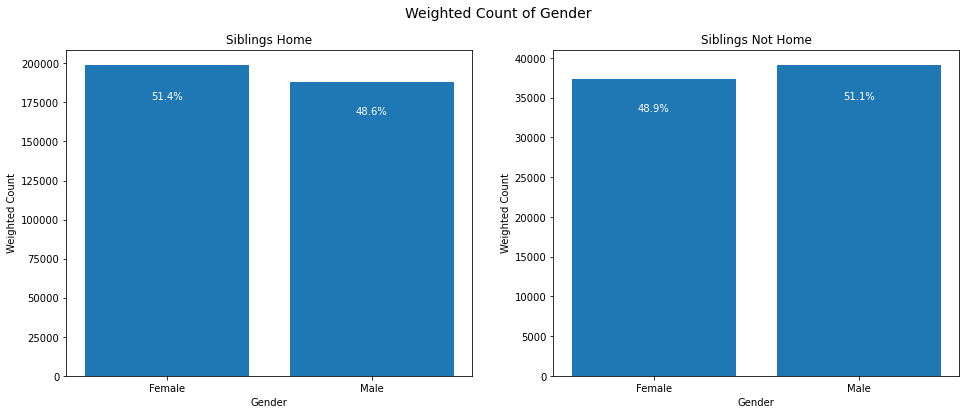

In [60]:
plot_biv_hist(df_resp_weight,
              'siblings_home',
              'gender',
              ['Siblings Home', 'Siblings Not Home'],
              'Gender')

> There doesn't appear to be a significant interaction between gender and whether both mother and father are home, or between gender and whether siblings are at home.

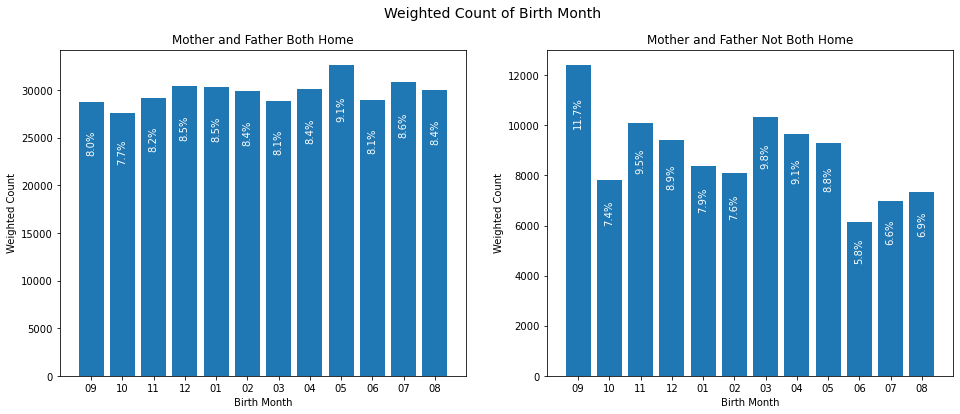

In [61]:
plot_biv_hist(df_resp_weight,
              'mother_and_father_home',
              'birth_month',
              ['Mother and Father Both Home', 'Mother and Father Not Both Home'],
              'Birth Month')

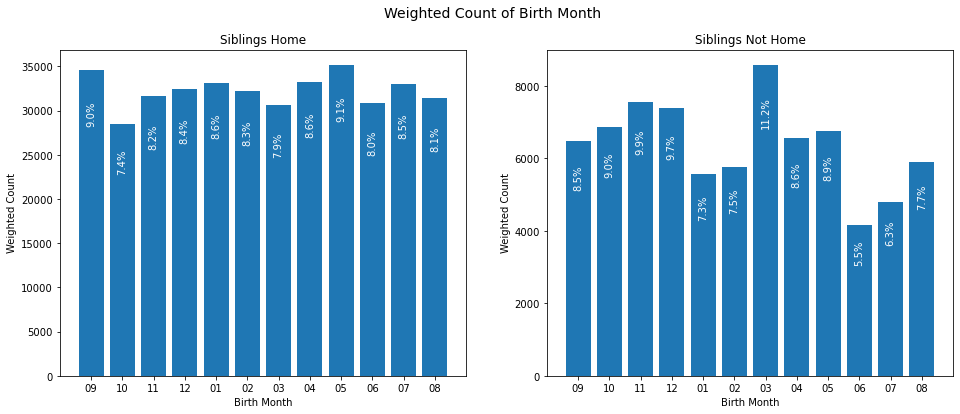

In [62]:
plot_biv_hist(df_resp_weight,
              'siblings_home',
              'birth_month',
              ['Siblings Home', 'Siblings Not Home'],
              'Birth Month')

> Bearing in mind the sample sizes for the right hand graphs are significantly smaller than those for the left hand side (and that the y-axes show weighted counts, which are much larger than the actual numbers in the sample) there doesn't appear to be an interaction between birth month and either whether mother and father are at home or siblings are at home.

### Explanatory variables and mindset responses

> Here, our earlier work creating the heatmap function will really pay off! We will explore the effect of each explanatory variable across every question set.

#### Gender

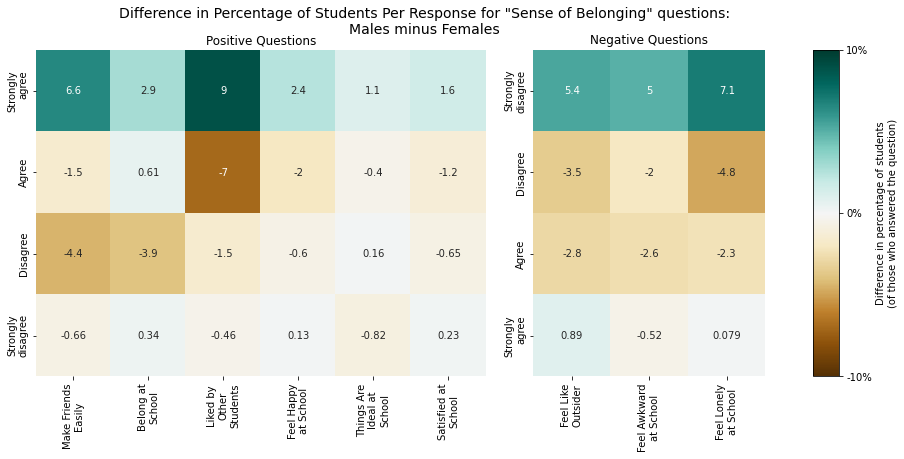

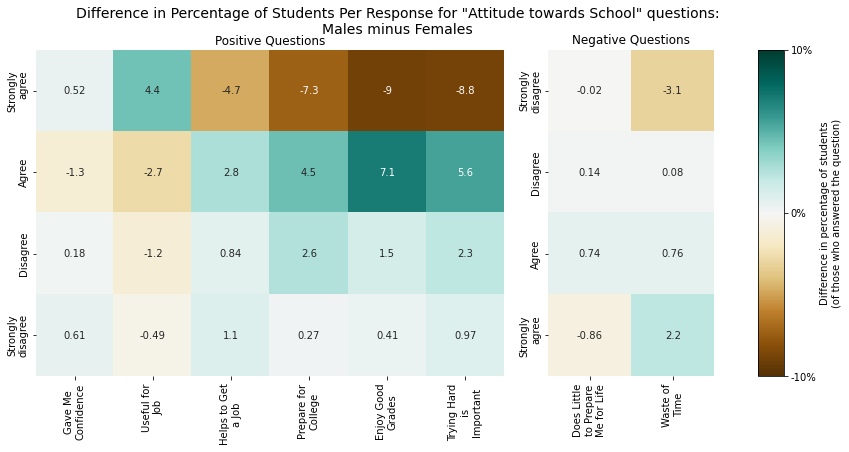

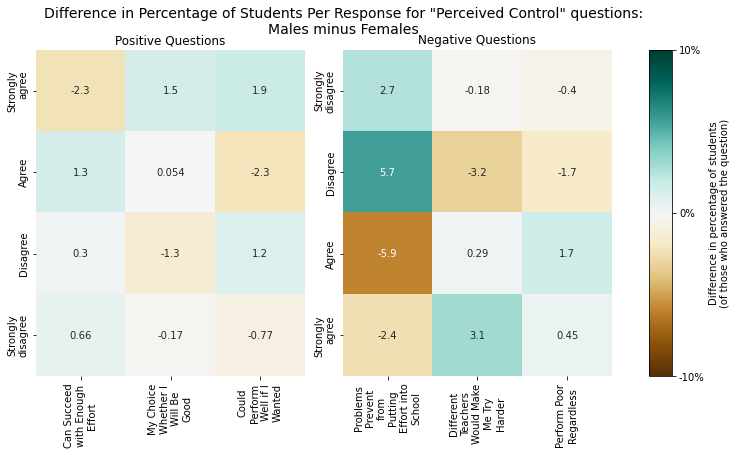

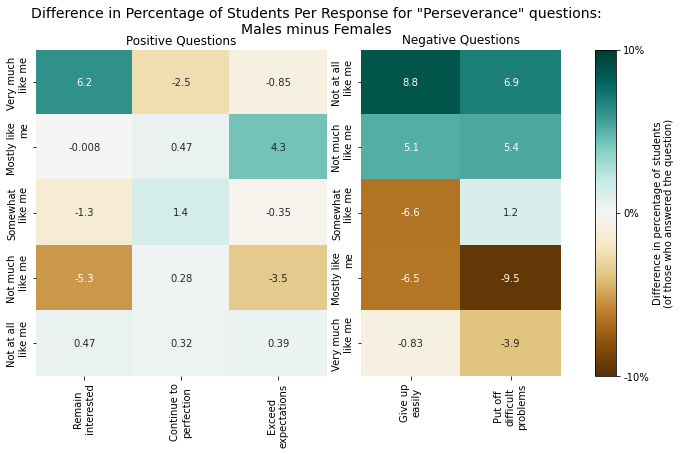

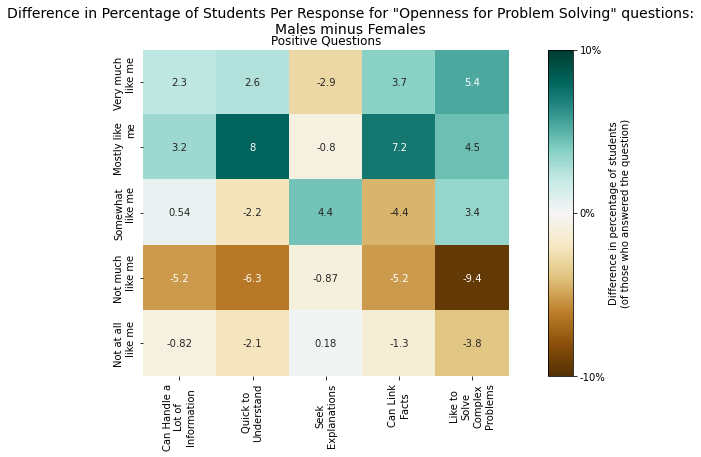

In [63]:
# Plot heatmaps to show the effect of gender across all question sets
for key, qset in qsets.items():
    plot_mindset_heatmap([df_resp_weight[df_resp_weight['gender']=='Male'],
                          df_resp_weight[df_resp_weight['gender']=='Female']],
                         qset,
                         'Males minus Females')

> Here we can see that males were generally more positive in almost every set of questions.

#### Mother and father both home

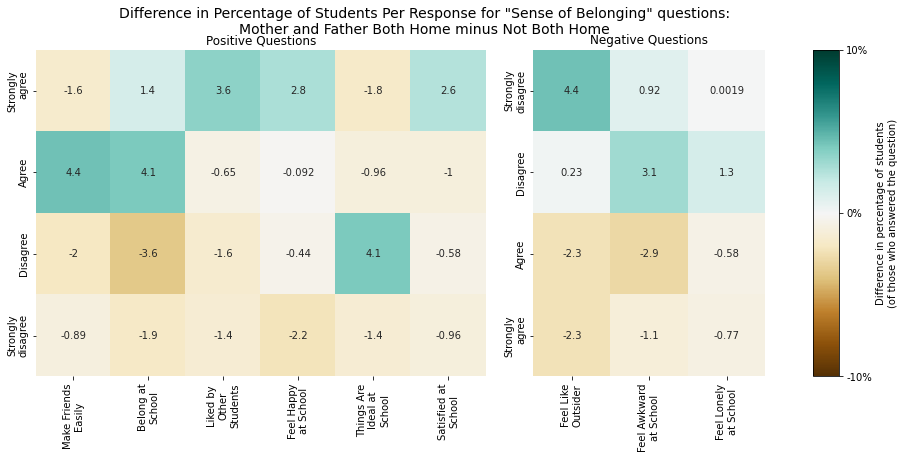

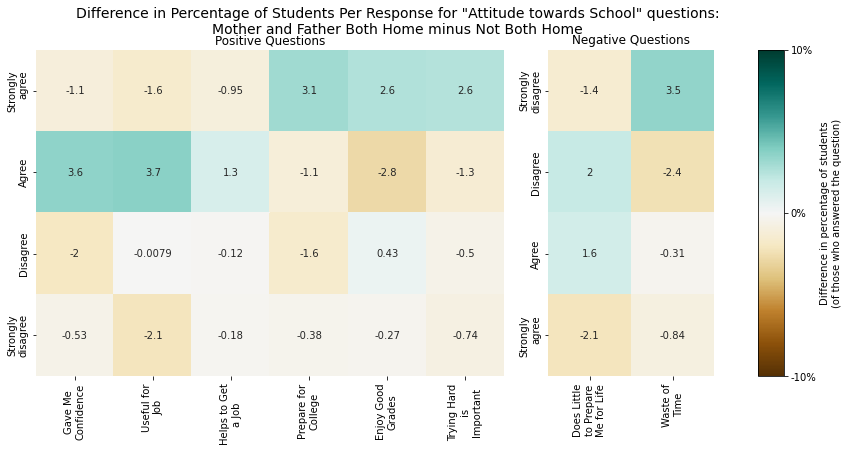

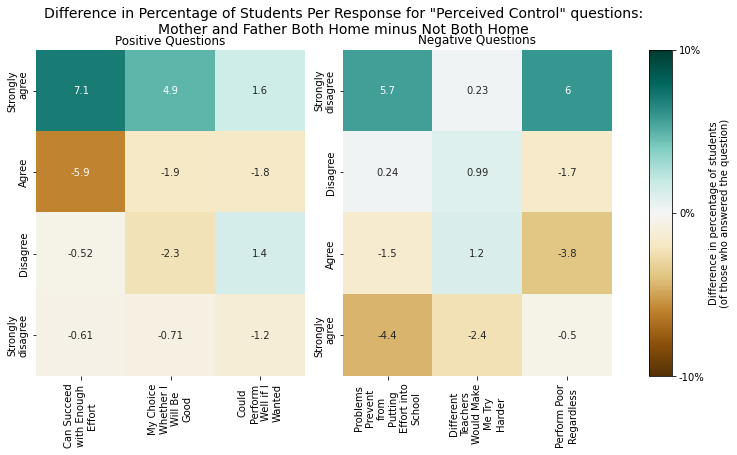

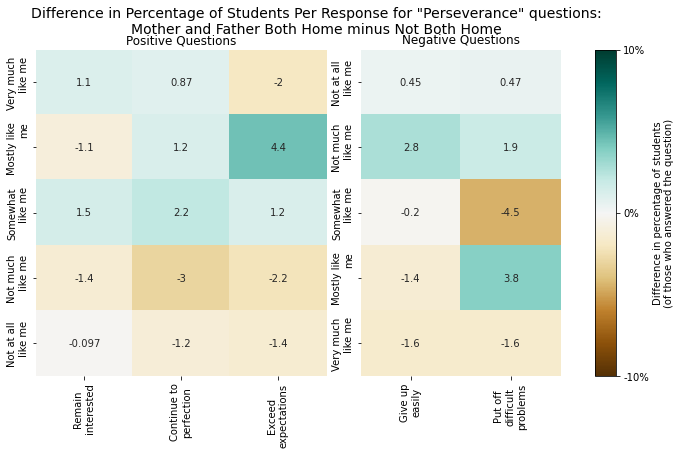

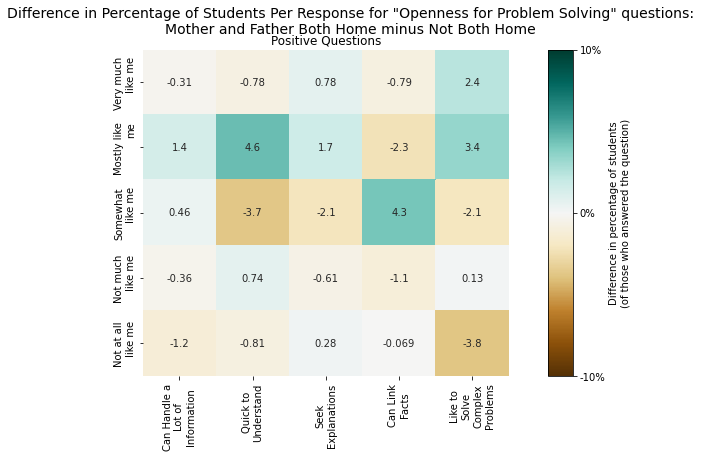

In [64]:
for key, qset in qsets.items():
    plot_mindset_heatmap([df_resp_weight[df_resp_weight['mother_and_father_home']==True], 
                          df_resp_weight[df_resp_weight['mother_and_father_home']==False]], 
                         qset, 
                         'Mother and Father Both Home minus Not Both Home')

> Here we can see that when mother and father are both at home, students are generally more positive.

#### Siblings home

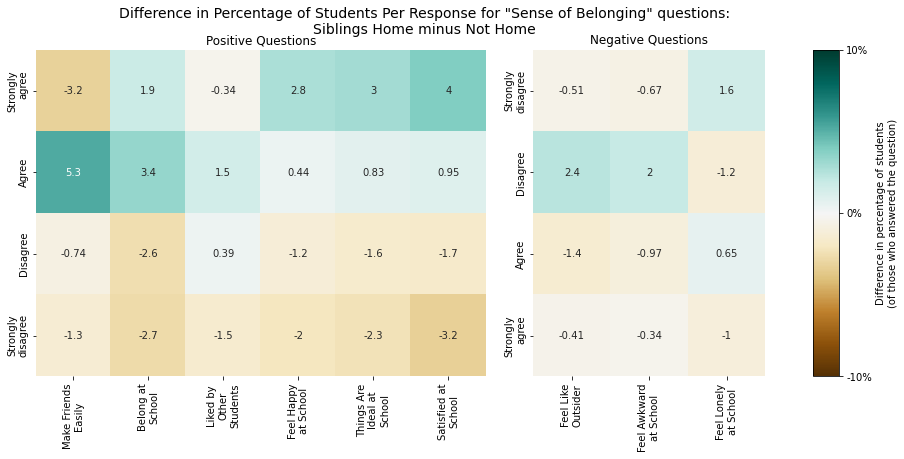

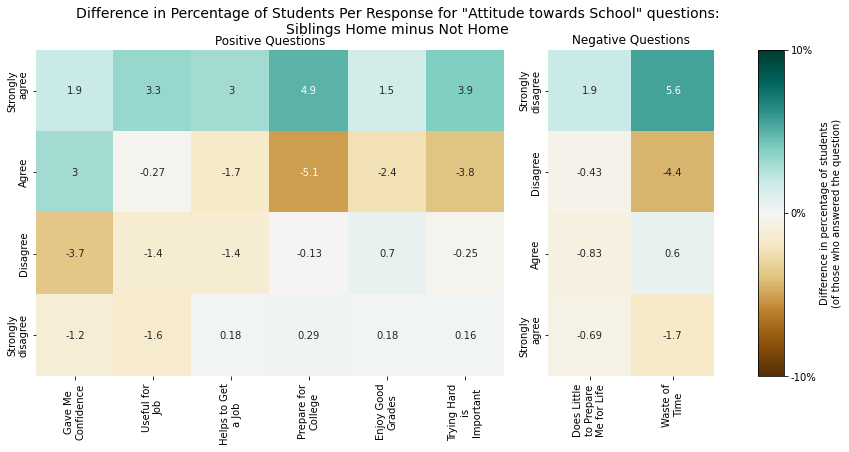

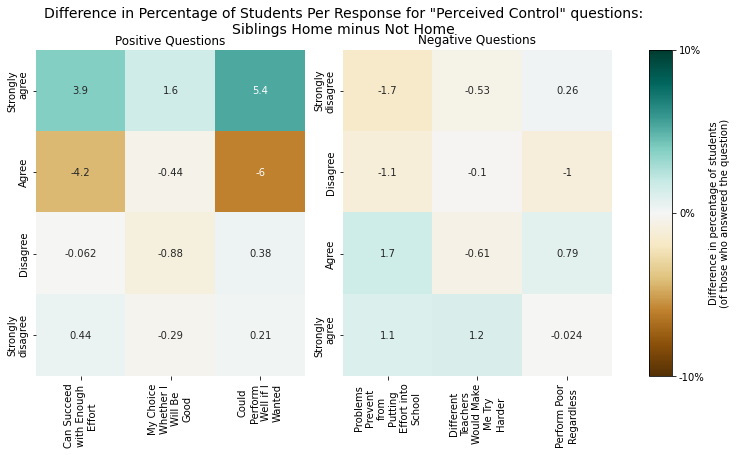

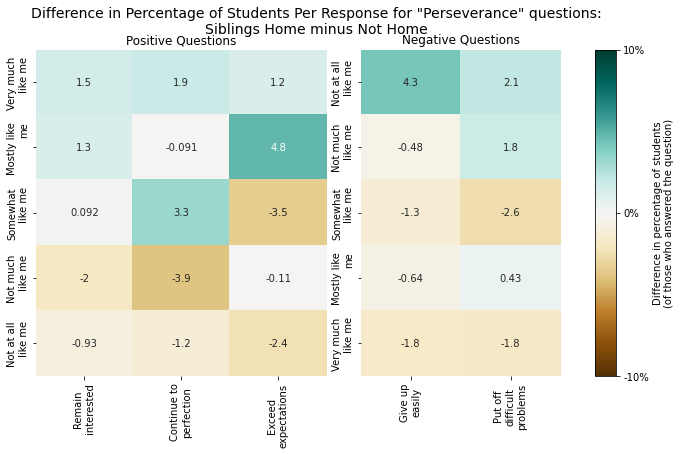

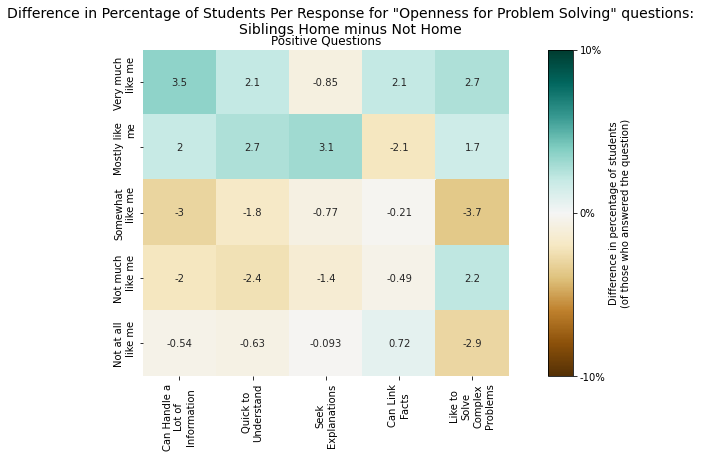

In [65]:
for key, qset in qsets.items():
    plot_mindset_heatmap([df_resp_weight[df_resp_weight['siblings_home']==True], 
                          df_resp_weight[df_resp_weight['siblings_home']==False]], 
                         qset, 
                         'Siblings Home minus Not Home')

> Here we can see that when siblings are at home, students are generally more positive.

#### Birth month

> Here we will compare the students born in the first third of the academic year with those born in the last third.

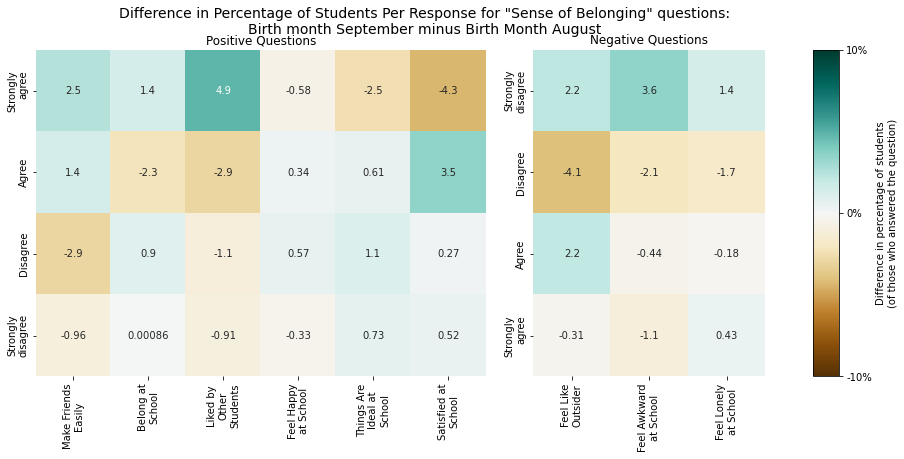

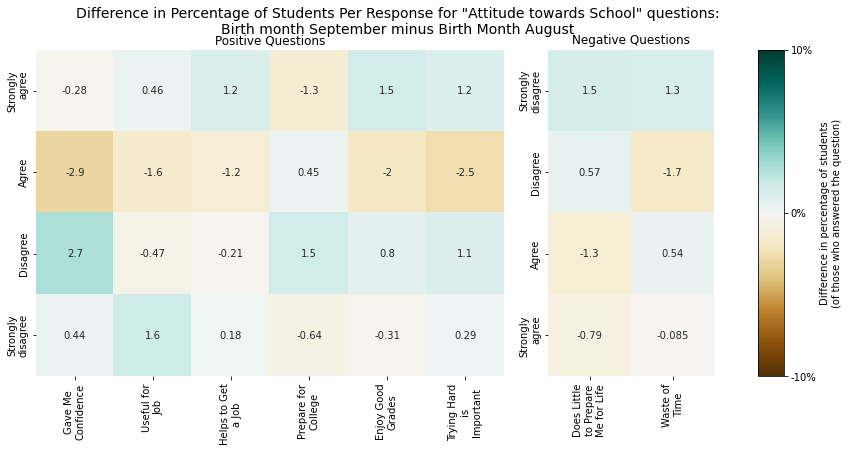

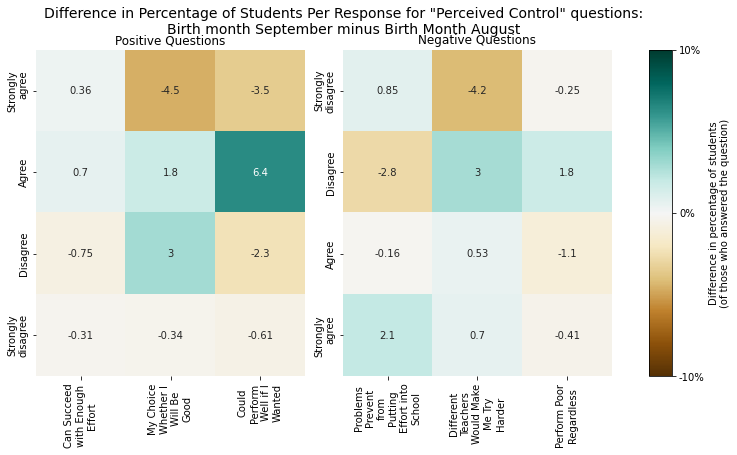

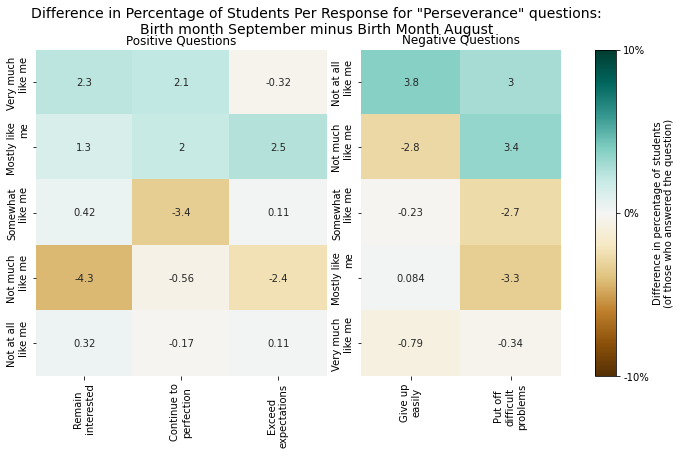

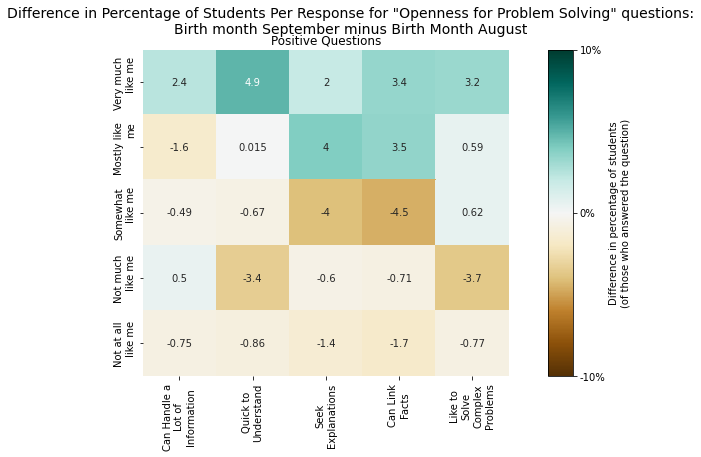

In [66]:
for key, qset in qsets.items():
    plot_mindset_heatmap([df_resp_weight[df_resp_weight['birth_month'].isin(['09', '10', '11', '12'])], 
                          df_resp_weight[df_resp_weight['birth_month'].isin(['05', '06', '07', '08'])]], 
                         qset, 
                         'Birth month September minus Birth Month August')

> Here we can see a mixed picture across the question sets, with some seeming affected by age within the year and others less so.

### Explanatory variables and proficiency

> Here we will explore the effect of each explanatory variable on proficiencies.

In [67]:
# Pull data together
df_resp_plaus = df_resp_clean.join(df_plaus_weight)
cols = [[f'PV{x}MATH' for x in range(1,6)], [f'PV{x}READ' for x in range(1,6)], [f'PV{x}SCIE' for x in range(1,6)]]
titles=['Mathematics', 'Reading', 'Science']

##### Gender

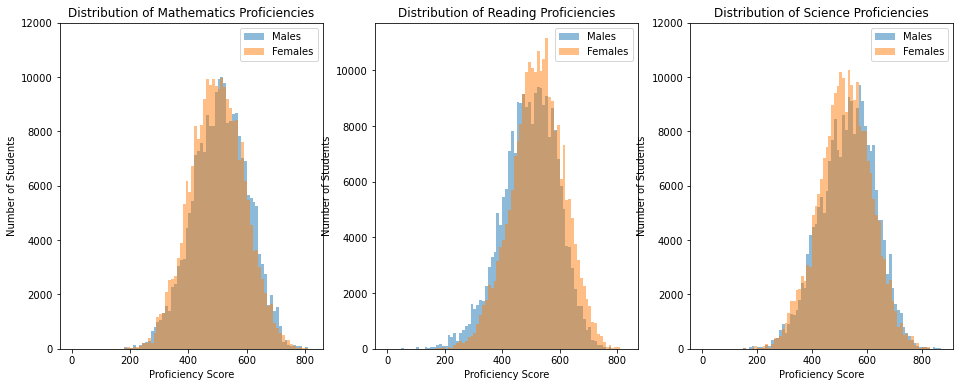

In [68]:
# Plot each facet on same axes for each proficiency
fig, ax = plt.subplots(1, 3, figsize=(16,6))
for i in range(0,3):
    plt.sca(ax[i])
    hist1 = plot_proficiency_hist(df_resp_plaus[df_resp_plaus['gender']=='Male'], cols[i], 10, titles[i])
    hist2 = plot_proficiency_hist(df_resp_plaus[df_resp_plaus['gender']=='Female'], cols[i], 10, titles[i])
    plt.legend([hist1, hist2], ['Males', 'Females'])

In [69]:
# Estimate population mean, its standard error, and population standard deviation for each facet
for i in range(0,3):
    print(titles[i])
    print('  Male: '+str(estimate_mean_std_dev(df_resp_plaus[df_resp_plaus['gender']=='Male'], cols[i])))
    print('  Female:'+str(estimate_mean_std_dev(df_resp_plaus[df_resp_plaus['gender']=='Female'], cols[i])))

Mathematics
  Male: {'est pop mean': 510.0167111943553, 'std err': 4.000119803979575, 'est pop std dev': 93.79866006483385}
  Female:{'est pop mean': 498.73295376894976, 'std err': 4.30332675925377, 'est pop std dev': 91.57166723764797}
Reading
  Male: {'est pop mean': 496.1267836885742, 'std err': 4.332007777617828, 'est pop std dev': 95.7155159506397}
  Female:{'est pop mean': 523.1515868259416, 'std err': 3.9053218022259513, 'est pop std dev': 90.62207030146828}
Science
  Male: {'est pop mean': 530.6272964605935, 'std err': 4.313127460466504, 'est pop std dev': 98.60399523988445}
  Female:{'est pop mean': 520.0063317329672, 'std err': 3.962283910503343, 'est pop std dev': 94.75647716587378}


> Males seem better at mathematics and science on average, and females better at reading on average.

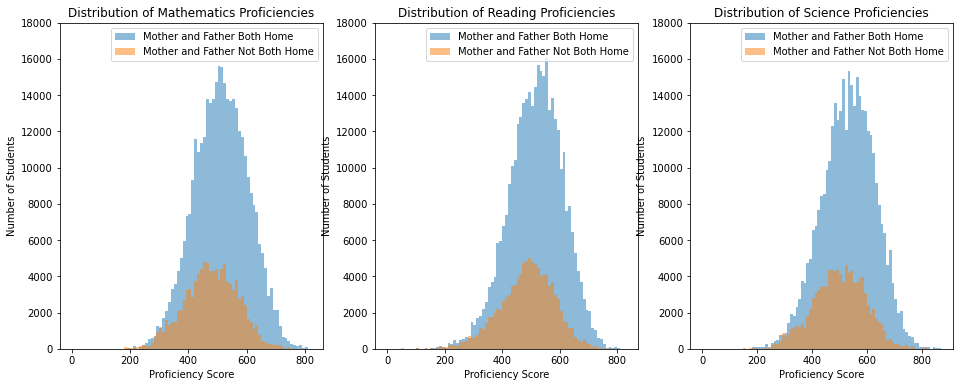

In [70]:
# Plot each facet on same axes for each proficiency
fig, ax = plt.subplots(1, 3, figsize=(16,6))
for i in range(0,3):
    plt.sca(ax[i])
    hist1 = plot_proficiency_hist(df_resp_plaus[df_resp_plaus['mother_and_father_home']==True], cols[i], 10, titles[i])
    hist2 = plot_proficiency_hist(df_resp_plaus[df_resp_plaus['mother_and_father_home']==False], cols[i], 10, titles[i])
    plt.legend([hist1, hist2], ['Mother and Father Both Home', 'Mother and Father Not Both Home'])

In [71]:
# Estimate population mean, its standard error, and population standard deviation for each facet
for i in range(0,3):
    print(titles[i])
    print('  Both home: '+str(estimate_mean_std_dev(
                                df_resp_plaus[df_resp_plaus['mother_and_father_home']==True], cols[i])))
    print('  Not both home:'+str(estimate_mean_std_dev(
                                df_resp_plaus[df_resp_plaus['mother_and_father_home']==False], cols[i])))

Mathematics
  Both home: {'est pop mean': 512.1452668855354, 'std err': 3.1506348137182973, 'est pop std dev': 92.0765629153706}
  Not both home:{'est pop mean': 477.69564135422445, 'std err': 5.309429093394292, 'est pop std dev': 90.44938931345823}
Reading
  Both home: {'est pop mean': 516.7493182003639, 'std err': 3.1894528852111135, 'est pop std dev': 93.06980168967247}
  Not both home:{'est pop mean': 486.8254365955603, 'std err': 5.234769252232267, 'est pop std dev': 94.00856829483553}
Science
  Both home: {'est pop mean': 532.7145797587013, 'std err': 3.262830109382881, 'est pop std dev': 96.05741592811061}
  Not both home:{'est pop mean': 499.9223573988276, 'std err': 5.285991196467324, 'est pop std dev': 95.02856872362072}


> All proficiencies seem higher on average when both mother and father are at home.

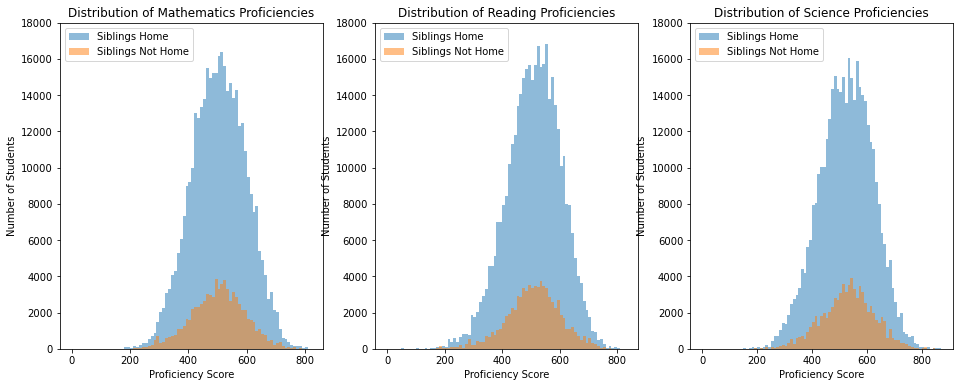

In [72]:
# Plot each facet on same axes for each proficiency
fig, ax = plt.subplots(1, 3, figsize=(16,6))
for i in range(0,3):
    plt.sca(ax[i])
    hist1 = plot_proficiency_hist(df_resp_plaus[df_resp_plaus['siblings_home']==True], cols[i], 10, titles[i])
    hist2 = plot_proficiency_hist(df_resp_plaus[df_resp_plaus['siblings_home']==False], cols[i], 10, titles[i])
    plt.legend([hist1, hist2], ['Siblings Home', 'Siblings Not Home'])

In [73]:
# Estimate population mean, its standard error, and population standard deviation for each facet
for i in range(0,3):
    print(titles[i])
    print('  Siblings home: '+str(estimate_mean_std_dev(
                                df_resp_plaus[df_resp_plaus['siblings_home']==True], cols[i])))
    print('  Siblings not home:'+str(estimate_mean_std_dev(
                                df_resp_plaus[df_resp_plaus['siblings_home']==False], cols[i])))

Mathematics
  Siblings home: {'est pop mean': 504.77552398399456, 'std err': 3.2802884845556073, 'est pop std dev': 93.00770035047213}
  Siblings not home:{'est pop mean': 501.6763391504671, 'std err': 5.091899074900488, 'est pop std dev': 91.94757423713932}
Reading
  Siblings home: {'est pop mean': 509.93665909625815, 'std err': 3.260150020332868, 'est pop std dev': 94.39584548477717}
  Siblings not home:{'est pop mean': 509.7371511368043, 'std err': 5.186388799951566, 'est pop std dev': 92.76593200365528}
Science
  Siblings home: {'est pop mean': 524.0949100703467, 'std err': 3.3168360299406277, 'est pop std dev': 97.16377128536575}
  Siblings not home:{'est pop mean': 530.872977369607, 'std err': 5.15954842132271, 'est pop std dev': 94.78637738635054}


> Presence of siblings at home doesn't appear to affect proficiency.

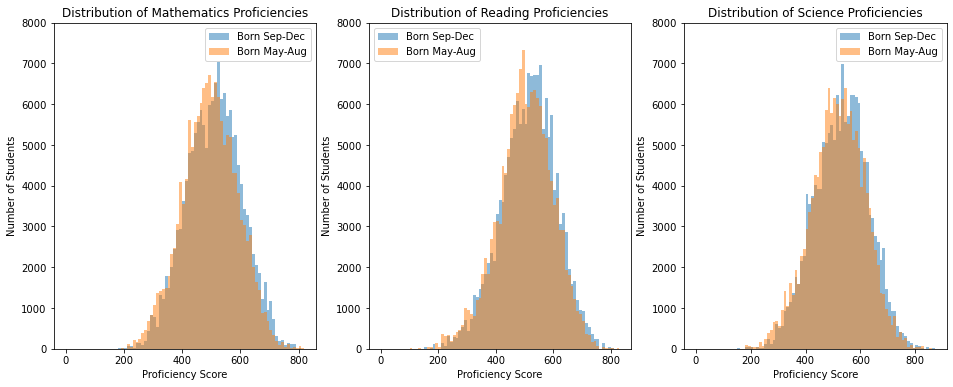

In [74]:
# Plot each facet on same axes for each proficiency
fig, ax = plt.subplots(1, 3, figsize=(16,6))
for i in range(0,3):
    plt.sca(ax[i])
    hist1 = plot_proficiency_hist(df_resp_plaus[df_resp_plaus['birth_month'].isin(['09', '10', '11', '12'])], cols[i], 10, titles[i])
    hist2 = plot_proficiency_hist(df_resp_plaus[df_resp_plaus['birth_month'].isin(['05', '06', '07', '08'])], cols[i], 10, titles[i])
    plt.legend([hist1, hist2], ['Born Sep-Dec', 'Born May-Aug'])

In [75]:
# Estimate population mean, its standard error, and population standard deviation for each facet
for i in range(0,3):
    print(titles[i])
    print('  Born Sep-Dec: '+str(estimate_mean_std_dev(
                                df_resp_plaus[df_resp_plaus['birth_month'].isin(['09', '10', '11', '12'])], cols[i])))
    print('  Born May-Aug:'+str(estimate_mean_std_dev(
                                df_resp_plaus[df_resp_plaus['birth_month'].isin(['05', '06', '07', '08'])], cols[i])))

Mathematics
  Born Sep-Dec: {'est pop mean': 509.7733186567578, 'std err': 4.712300886859098, 'est pop std dev': 94.5821999931727}
  Born May-Aug:{'est pop mean': 495.50943441044836, 'std err': 3.8075867555632654, 'est pop std dev': 93.805578429828}
Reading
  Born Sep-Dec: {'est pop mean': 513.9321005339218, 'std err': 4.5696888348634825, 'est pop std dev': 95.66463483568086}
  Born May-Aug:{'est pop mean': 502.35243638435804, 'std err': 4.136685999235335, 'est pop std dev': 95.94183587556995}
Science
  Born Sep-Dec: {'est pop mean': 529.4916690630117, 'std err': 4.544198622500247, 'est pop std dev': 97.94471989605518}
  Born May-Aug:{'est pop mean': 516.5179928732736, 'std err': 3.9550845055849635, 'est pop std dev': 98.04634058073555}


> All proficiencies seem higher on average for students born in the first third of the academic year compared to those born in the last third.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Here we will summarise broad findings rather than drill down into specifics.
>
> Male students had, on average, a more positive mindset than female students, with exceptions in some areas. Male students seemed, on average, more proficient in mathematics and science, and less proficient in reading than female students.
>
> Students with both mother and father at home had, on average, a more positive mindset than without both at home. They also seemed, on average, more proficient in mathematics, science and reading.
>
> Students with siblings at home had, on average, a more positive mindset than those without. There was no difference in proficiencies in mathematics, science and reading.
>
> Students born in the first third of the academic year had, on average, a more positive mindset than those born in the last third. They also seemed, on average, more proficient in mathematics, science and reading.
>
> A feature of interest discovered here is the question `ST91Q03` ("Perceived Control - Problems Prevent Me From Putting Effort Into School"), which showed a large effect due to gender and also a large effect due to mother and father both being at home or not. This will be explored further.
>
> It should be noted that tests for statistical significance were not carried out due to the complex nature of the sampling techniques, and the lack of independence between mindset questions.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> No, they purely exist to facilitate unbiased analysis.

## Multivariate Exploration

> Here we will further explore question `ST91Q03` ("Perceived Control - Problems Prevent Me From Putting Effort Into School") looking at how responses vary both with gender and mother and father both being at home or not.

In [76]:
# Prepare data
facets = [['Male', True],['Male', False],['Female', True],['Female', False]]

data = [prep_heatmap_data(df_resp_weight[(df_resp_weight['gender']==f[0]) &
                                         (df_resp_weight['mother_and_father_home']==f[1])],
                          {'neg':['ST91Q03']}) for f in facets]

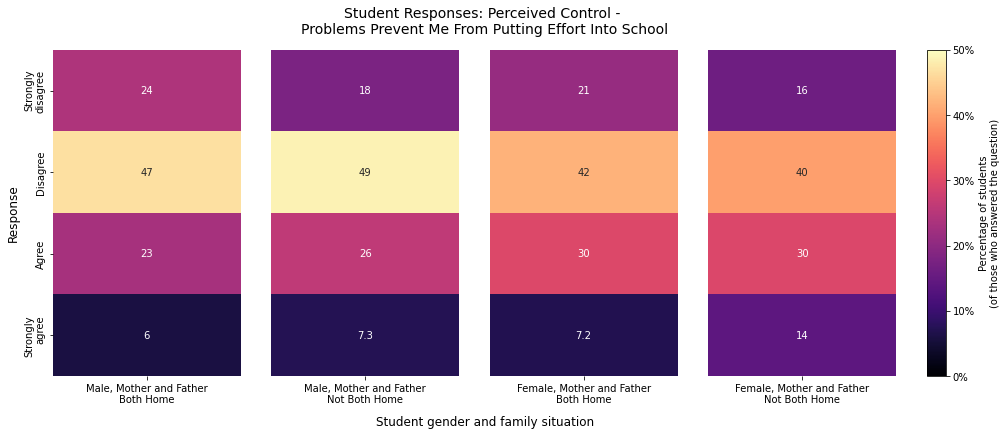

In [77]:
# Prepare subplots and axes
fig, ax = plt.subplots(1, 5, figsize=(16,6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.1]})
plt.suptitle('Student Responses: Perceived Control - ' +
             '\nProblems Prevent Me From Putting Effort Into School', fontsize=14)

# Plot heatmaps
for i in range(len(data)):    
    #Plot heatstrip
    plt.sca(ax[i])
    sb.heatmap(data=data[i]['neg'], 
               vmin=0, 
               vmax=50, 
               cbar=False, 
               cmap='magma', 
               annot=True)
    
    # Set x tick labels
    xticklabel = ', Mother and Father Both Home' if facets[i][1] == True else ', Mother and Father Not Both Home'
    xticklabel = facets[i][0] + xticklabel
    xticklabel = add_linebreaks([xticklabel], 25)
    ax[i].set_xticklabels(xticklabel)

    # Process repsonse texts for y tick labels
    ylabs = [y.get_text() for y in ax[i].get_yticklabels()]
    ax[i].set_yticklabels(add_linebreaks(ylabs, 12))
    plt.yticks(rotation=90, va='center')
    
    # Share y-axis (except colorbar)
    plt.ylabel('Response', fontsize=12)
    ax[i].yaxis.set_visible(False) if i > 0 else True

# Add shared x axis label
plt.figtext(0.5, 0.01, 'Student gender and family situation', ha="center", fontsize=12)
    
# Add colorbar
cb = ax[-1]
plt.sca(cb)
cbar = fig.colorbar(ax[0].collections[0], cax=cb, ticks=[x for x in range(0, 51, 10)])
cbar.set_ticklabels([str(x)+'%' for x in range(0, 51, 10)])
plt.ylabel('Percentage of students\n(of those who answered the question)');

> Here it seems that gender is a stronger factor than mother and father both being at home in how likely the student is to feel that problems prevent them from putting effort into school. However the two features seem to have an additive effect on this aspect of student mindset. Males with mother and father both at home are the least likely to agree to some extent, and females with mother and father not both home are the most likely to agree to some extent.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> There seem to be advantages in terms of student mindset to being male, born early in the academic year, and having mother, father and siblings at home.
>
> Males' average proficiency at mathematics and science is higher than that of females, while the reverse is true for reading.
>
> There seem to be advantages in terms of student proficiency to being born early in the academic year, and having mother and father both home.
>
> While tests of statistical significance were not performed, the results on the mindset questions were reinforced by the number of related questions that showed these trends. It should be noted that there were some exceptions however.

### Were there any interesting or surprising interactions between features?

> It was interesting and surprising to discover that gender had a larger effect than the absence of a mother or father on students perception of problems preventing them from putting effort into school.